## Device Stuff

In [53]:
import torch

#Set up device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Dataset

In [54]:
import os
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [55]:
from utils import get_classes_indexes

In [56]:
source_folder = os.path.join('data', 'internal', 'preprocessed_videos')

def create_dataframe(videos_root):
    data = []
    
    classes_to_extract = os.listdir(videos_root)
    
    classes_data = get_classes_indexes(class_file_name="data/raw/dataset/wlasl_class_list.txt", classes_to_extract=classes_to_extract)

    CLASS_TO_IDX = {class_name : idx for (idx, class_name) in  classes_data}
    IDX_TO_CLASS = {idx : class_name for (idx, class_name) in  classes_data}
    
    for class_name in os.listdir(videos_root):
        class_path = os.path.join(videos_root, class_name)
        for name in os.listdir(class_path):
            name = Path(name).stem
            data.append([name, CLASS_TO_IDX[class_name], class_name])
    return pd.DataFrame(data, columns=['video_name', 'class_id', 'class_name'])

dataset = create_dataframe(source_folder)

dataset.sample(20)

,video_name,class_id,class_name
53,WIN_20231127_20_12_12_Pro,1164,me
349,WIN_20231127_19_28_18_Pro,259,baby
156,WIN_20231127_20_14_35_Pro,566,my
59,WIN_20231127_20_11_14_Pro,1164,me
348,WIN_20231127_19_29_12_Pro,259,baby
205,WIN_20231127_20_25_52_Pro,179,you
270,63188,1999,whistle
93,WIN_20231127_19_37_10_Pro,35,can
125,WIN_20231127_00_26_25_Pro,1721,due
248,WIN_20231127_20_21_39_Pro,1999,whistle


In [57]:
import cv2

max_frame_count = 0

for key, row in dataset.iterrows():
    class_name = row['class_name']
    file_name = row['video_name']
    file_path = os.path.join(source_folder, class_name, file_name+'.mp4')
    cap = cv2.VideoCapture(file_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    max_frame_count = max(max_frame_count, length)
    
print('Maximum frame count:',max_frame_count)

Maximum frame count: 168


In [58]:
IDX_TO_CLASS = [ c_id for i, c_id in enumerate(set(dataset.class_id))]
CLASS_TO_IDX = { c_id: i for i, c_id in enumerate(IDX_TO_CLASS)}

In [59]:
from os.path import exists
import torch.nn.functional as F

class ASLDataset(Dataset):
    """
    A custom dataset class for loading American Sign Language (ASL) videos and their corresponding labels.

    Args:
        tensors_folder (str): Path to the folder containing the .pt arrays (converted videos).
        dataset_df (DataFrame): Pandas dataframe with information about videos
        max_frame_count (int): Maximum length of video in frames.
        ohe (OneHotEncoder): Required to encode class id to one hot numeric array.

    Attributes:
        tensors_folder (str): Path to the folder containing the .pt arrays (converted videos).
        name_with_label (dict): A dictionary mapping video names to their labels.
        classes (list): A list of class names.
    """

    def __init__(self, tensors_folder: str, dataset_df: pd.DataFrame, max_frame_count: int) -> None:
        # Default frame (set of points) to insert in short videos to make all videos equal in length
        default_frame = [0] * (21 * 3 * 2 + 33 * 3)
        
        self.tensor_sequences = []
        self.targets = []
        for i, row in dataset_df.iterrows():
            path_to_tensor = tensors_folder + '/' + row["video_name"] + '.pt'
            
            if not exists(path_to_tensor):
                continue
            
            # Open the video file using OpenCV
            tensor = torch.load(path_to_tensor)

            # Change length of video (not a video but sequence of frames with points coordinates in each frame)
            # pad_right = [default_frame for _ in range(0, max_frame_count - tensor.shape[0])]
            # pad_right = torch.tensor(pad_right)
            # self.tensor_sequences.append(torch.cat((pad_right, F.normalize(tensor.float(), dim=1))))
            self.tensor_sequences.append(F.normalize(tensor.float(), dim=1))
            self.targets.append(CLASS_TO_IDX[dataset_df["class_id"][i]])
        self.targets = torch.tensor(self.targets)
            
            
    def __len__(self):
        """
        Returns the number of videos in the dataset.

        Returns:
            int: The number of videos in the dataset.
        """
        return len(self.targets)

    def __getitem__(self, index):
        """
        Retrieves a video and its corresponding label from the dataset.

        Args:
            index (int): The index of the video to retrieve.

        Returns:
            tuple: A tuple containing the video frames as a PyTorch tensor and the label.
        """

        return self.tensor_sequences[index].float(), self.targets[index].long()


In [60]:
def read_classes(path):
    classes = dict()
    with open(path, 'r') as file:
        for line in file:
            line = line.strip().split('\t')
            key = int(line[0])
            value = line[1]
            classes[key] = value
    return classes

In [61]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [62]:
classes = read_classes('data/raw/dataset/wlasl_class_list.txt')

train_dataset = ASLDataset('data/internal/features', train, max_frame_count)
#val_dataset = ASLDataset('data/internal/features', val, max_frame_count)
test_dataset = ASLDataset('data/internal/features', test, max_frame_count)

In [63]:
# Create dataloaders
batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}")
#print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 284
Test size: 71


## Model

In [64]:
import matplotlib.pyplot as plt

In [ ]:
dropout = 0.4

In [65]:
import torch.nn as nn

class SequenceModel(nn.Module):
    def __init__(self, input_size, output_size) -> None:
        super().__init__()
        self.lstm1 = nn.Sequential(
            nn.LSTM(input_size, 64, 1, batch_first=True, dropout=dropout),
        )
        self.lstm2 = nn.Sequential(
            nn.LSTM(64, 128, 1, batch_first=True, dropout=dropout),
        )
        self.lstm3 = nn.Sequential(
            nn.LSTM(128, 64, 1, batch_first=True, bidirectional=True, dropout=dropout),
        )
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.linear = nn.Sequential(
            nn.Linear(64 * 2, 32),
            nn.ReLU(),
            nn.Linear(32, output_size),
        )

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.relu1(x)
        x, _ = self.lstm2(x)
        x = self.relu2(x)
        #x, _ = self.lstm3(x)
        #x = self.relu3(x)
        x = self.linear(x[:,-1,:])

        return x

## Training

In [66]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm


def train_model(model: nn.Module, epochs: int, criterion, optimizer, ckpt_path='models/best.pt'):
    """
    Function that trains model using number of epochs, loss function, optimizer.
    Can use validation or test data set for evaluation.
    Calculates f1 score.

    Parameter
    ---------
    model : nn.Module
      Model to train.
    epochs: int
      Number of train epochs
    criterion
      The loss function from pytorch
    optimizer
      The optimizer from pytorch
    """

    model.train()
    model.to(device)

    history = {'train_losses': [], 'test_losses': [],
               'train_scores': [], 'test_scores': []}

    # Train the model
    for epoch in range(epochs):
        model.train()

        predicted_train = []
        true_train = []

        train_loss = 0.0

        bar = tqdm(train_dataloader)
        iterations = 0

        for inputs, targets in bar:
          
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            train_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Get predicted classes and true classes from data
            predictions = torch.argmax(outputs, dim=1)
            for item in predictions:
                predicted_train.append(item.cpu().numpy())
            for item in targets:
                true_train.append(item.cpu().numpy())
            iterations += 1
            bar.set_postfix(
                ({"loss": f"{train_loss/(iterations*train_dataloader.batch_size)}"}))

        # Computing loss
        train_loss /= len(train_dataset)
        # Computing f1 score
        train_f1 = f1_score(true_train, predicted_train, average="macro")

        # Printing information in the end of train loop
        test_loss, test_f1 = test_model(model, criterion, test_dataloader)

        history['train_losses'].append(train_loss)
        history['test_losses'].append(test_loss)
        history['train_scores'].append(train_f1)
        history['test_scores'].append(test_f1)

        if test_f1 > max(history['test_scores']):
            torch.save(model.state_dict(), ckpt_path)

        print(f"Epoch {epoch+1} train (loss: {train_loss:.4f}, f1 score: {train_f1:.4f}) test (loss: {test_loss:.4f}, f1 score: {test_f1:.4f})")

    return history


def test_model(model: nn.Module, criterion, test_dataloader: DataLoader):
    """
    Function that evaluates model on specified dataloader
    by specified loss function.

    Parameter
    ---------
    model : nn.Module
      Model to train.
    criterion
      The loss function from pytorch
    test_dataloader: DataLoader
      The dataset for testing model

    Returns
    -------
    float: loss of model on given dataset
    float: f1 score of model on given dataset
    """

    model.eval()
    model.to(device)

    # Test loss value
    test_loss = 0.0

    # Lists for calculation f1 score
    predicted_test = []
    true_test = []

    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            test_loss += criterion(outputs, targets)

            # Get predicted classes and true classes from data
            predictions = torch.argmax(outputs, dim=1)
            for item in predictions:
                predicted_test.append(item.cpu().numpy())
            for item in targets:
                true_test.append(item.cpu().numpy())

    # Computation of test loss
    test_loss /= len(test_dataloader)

    # Computation of f1 score
    test_f1 = f1_score(true_test, predicted_test, average="macro")
    return test_loss.item(), test_f1

In [67]:
model = SequenceModel(input_size=225, output_size=len(IDX_TO_CLASS))
#model = LSTM_ResNet34(fc_size=225, num_classes=len(IDX_TO_CLASS), sample_duration=16)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/home/dmitrii/anaconda3/envs/detoxification_env/lib/python3.9/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [68]:
history = train_model(model, 500, criterion, optimizer, ckpt_path='models/simple_lstm/best.pt')

  6%|▌         | 17/284 [00:00<00:01, 169.00it/s, loss=2.4473053336143495]

100%|██████████| 284/284 [00:01<00:00, 187.41it/s, loss=2.4952948244524675]


Epoch 1 train (loss: 2.4953, f1 score: 0.0169) test (loss: 2.4939, f1 score: 0.0187)


100%|██████████| 284/284 [00:01<00:00, 230.06it/s, loss=2.4784457943808866]


Epoch 2 train (loss: 2.4784, f1 score: 0.0287) test (loss: 2.4873, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 215.11it/s, loss=2.4476281803258706]


Epoch 3 train (loss: 2.4476, f1 score: 0.0197) test (loss: 2.4946, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 182.69it/s, loss=2.437131320926505] 


Epoch 4 train (loss: 2.4371, f1 score: 0.0197) test (loss: 2.4973, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 211.51it/s, loss=2.4335454962622953]


Epoch 5 train (loss: 2.4335, f1 score: 0.0197) test (loss: 2.4959, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 186.74it/s, loss=2.430514030473333] 


Epoch 6 train (loss: 2.4305, f1 score: 0.0197) test (loss: 2.4913, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 184.79it/s, loss=2.4277260740038376]


Epoch 7 train (loss: 2.4277, f1 score: 0.0197) test (loss: 2.4906, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 179.28it/s, loss=2.424876956452786] 


Epoch 8 train (loss: 2.4249, f1 score: 0.0197) test (loss: 2.4889, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 191.16it/s, loss=2.4230602572501545]


Epoch 9 train (loss: 2.4231, f1 score: 0.0197) test (loss: 2.4866, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 186.04it/s, loss=2.420776189213068] 


Epoch 10 train (loss: 2.4208, f1 score: 0.0197) test (loss: 2.4856, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 209.83it/s, loss=2.419245502898391] 


Epoch 11 train (loss: 2.4192, f1 score: 0.0197) test (loss: 2.4849, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 225.27it/s, loss=2.4168841712911364]


Epoch 12 train (loss: 2.4169, f1 score: 0.0197) test (loss: 2.4811, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 204.11it/s, loss=2.415482436267423] 


Epoch 13 train (loss: 2.4155, f1 score: 0.0197) test (loss: 2.4791, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 195.01it/s, loss=2.414759937726276] 


Epoch 14 train (loss: 2.4148, f1 score: 0.0197) test (loss: 2.4792, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 227.33it/s, loss=2.4126725112888177]


Epoch 15 train (loss: 2.4127, f1 score: 0.0197) test (loss: 2.4782, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 188.07it/s, loss=2.4113545451365725]


Epoch 16 train (loss: 2.4114, f1 score: 0.0197) test (loss: 2.4751, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 165.98it/s, loss=2.4097929760603836]


Epoch 17 train (loss: 2.4098, f1 score: 0.0197) test (loss: 2.4701, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 159.28it/s, loss=2.409079056390574] 


Epoch 18 train (loss: 2.4091, f1 score: 0.0197) test (loss: 2.4727, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 165.06it/s, loss=2.4087922040005805]


Epoch 19 train (loss: 2.4088, f1 score: 0.0197) test (loss: 2.4677, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 159.61it/s, loss=2.394655496301785] 


Epoch 20 train (loss: 2.3947, f1 score: 0.0197) test (loss: 2.4312, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 159.73it/s, loss=2.3670147128508123]


Epoch 21 train (loss: 2.3670, f1 score: 0.0487) test (loss: 2.4072, f1 score: 0.0651)


100%|██████████| 284/284 [00:01<00:00, 151.46it/s, loss=2.411738394431665] 


Epoch 22 train (loss: 2.4117, f1 score: 0.0475) test (loss: 2.4599, f1 score: 0.0169)


100%|██████████| 284/284 [00:01<00:00, 150.11it/s, loss=2.3498505786271164]


Epoch 23 train (loss: 2.3499, f1 score: 0.0407) test (loss: 2.3938, f1 score: 0.0785)


100%|██████████| 284/284 [00:01<00:00, 152.74it/s, loss=2.31159179269428]  


Epoch 24 train (loss: 2.3116, f1 score: 0.0824) test (loss: 2.3239, f1 score: 0.0687)


100%|██████████| 284/284 [00:01<00:00, 155.85it/s, loss=2.3057710838989474]


Epoch 25 train (loss: 2.3058, f1 score: 0.0673) test (loss: 2.3242, f1 score: 0.0690)


100%|██████████| 284/284 [00:01<00:00, 149.73it/s, loss=2.27580435888868]  


Epoch 26 train (loss: 2.2758, f1 score: 0.0616) test (loss: 2.2597, f1 score: 0.0701)


100%|██████████| 284/284 [00:01<00:00, 174.08it/s, loss=2.222618384680278] 


Epoch 27 train (loss: 2.2226, f1 score: 0.0723) test (loss: 2.2192, f1 score: 0.0730)


100%|██████████| 284/284 [00:01<00:00, 191.56it/s, loss=2.222017443935636] 


Epoch 28 train (loss: 2.2220, f1 score: 0.0851) test (loss: 2.2401, f1 score: 0.0769)


100%|██████████| 284/284 [00:01<00:00, 172.34it/s, loss=2.226879787696919] 


Epoch 29 train (loss: 2.2269, f1 score: 0.0753) test (loss: 2.3433, f1 score: 0.0923)


100%|██████████| 284/284 [00:01<00:00, 159.05it/s, loss=2.1401250055977994]


Epoch 30 train (loss: 2.1401, f1 score: 0.0706) test (loss: 2.3302, f1 score: 0.0590)


100%|██████████| 284/284 [00:01<00:00, 151.62it/s, loss=2.103585933295774] 


Epoch 31 train (loss: 2.1036, f1 score: 0.0683) test (loss: 2.0746, f1 score: 0.0673)


100%|██████████| 284/284 [00:01<00:00, 163.25it/s, loss=2.0698554154852746]


Epoch 32 train (loss: 2.0699, f1 score: 0.0674) test (loss: 2.0618, f1 score: 0.0683)


100%|██████████| 284/284 [00:01<00:00, 216.72it/s, loss=2.0169472988222688]


Epoch 33 train (loss: 2.0169, f1 score: 0.0806) test (loss: 2.0324, f1 score: 0.1137)


100%|██████████| 284/284 [00:01<00:00, 191.10it/s, loss=1.983401141536068] 


Epoch 34 train (loss: 1.9834, f1 score: 0.0889) test (loss: 2.0280, f1 score: 0.1082)


100%|██████████| 284/284 [00:01<00:00, 174.23it/s, loss=2.018704910933132] 


Epoch 35 train (loss: 2.0187, f1 score: 0.0739) test (loss: 2.0233, f1 score: 0.0680)


100%|██████████| 284/284 [00:01<00:00, 157.13it/s, loss=1.9864786481353598]


Epoch 36 train (loss: 1.9865, f1 score: 0.0700) test (loss: 2.0309, f1 score: 0.0716)


100%|██████████| 284/284 [00:01<00:00, 164.29it/s, loss=1.9573586230546656]


Epoch 37 train (loss: 1.9574, f1 score: 0.0770) test (loss: 2.0024, f1 score: 0.0923)


100%|██████████| 284/284 [00:01<00:00, 143.92it/s, loss=1.9253198546423038]


Epoch 38 train (loss: 1.9253, f1 score: 0.0802) test (loss: 1.9734, f1 score: 0.0794)


100%|██████████| 284/284 [00:01<00:00, 153.74it/s, loss=1.9259327922908354]


Epoch 39 train (loss: 1.9259, f1 score: 0.0880) test (loss: 2.0213, f1 score: 0.0887)


100%|██████████| 284/284 [00:01<00:00, 151.91it/s, loss=1.8890922787323805]


Epoch 40 train (loss: 1.8891, f1 score: 0.0749) test (loss: 1.9413, f1 score: 0.0823)


100%|██████████| 284/284 [00:01<00:00, 148.98it/s, loss=1.8805276654975516]


Epoch 41 train (loss: 1.8805, f1 score: 0.0701) test (loss: 2.4794, f1 score: 0.0446)


100%|██████████| 284/284 [00:01<00:00, 151.68it/s, loss=1.871978287545728] 


Epoch 42 train (loss: 1.8720, f1 score: 0.0673) test (loss: 1.9310, f1 score: 0.0716)


100%|██████████| 284/284 [00:01<00:00, 158.98it/s, loss=1.8536889112331498]


Epoch 43 train (loss: 1.8537, f1 score: 0.0926) test (loss: 1.8996, f1 score: 0.0850)


100%|██████████| 284/284 [00:01<00:00, 153.08it/s, loss=1.862922210088918] 


Epoch 44 train (loss: 1.8629, f1 score: 0.0795) test (loss: 1.9228, f1 score: 0.0850)


100%|██████████| 284/284 [00:01<00:00, 191.85it/s, loss=1.839776852601011] 


Epoch 45 train (loss: 1.8398, f1 score: 0.1093) test (loss: 1.8955, f1 score: 0.0850)


100%|██████████| 284/284 [00:01<00:00, 207.50it/s, loss=1.840134493481945] 


Epoch 46 train (loss: 1.8401, f1 score: 0.0965) test (loss: 1.8795, f1 score: 0.1002)


100%|██████████| 284/284 [00:01<00:00, 166.71it/s, loss=1.820277257284648] 


Epoch 47 train (loss: 1.8203, f1 score: 0.1025) test (loss: 1.8710, f1 score: 0.1046)


100%|██████████| 284/284 [00:01<00:00, 206.90it/s, loss=1.8112181391514524]


Epoch 48 train (loss: 1.8112, f1 score: 0.1028) test (loss: 1.9245, f1 score: 0.1317)


100%|██████████| 284/284 [00:01<00:00, 203.21it/s, loss=1.8067720545009829]


Epoch 49 train (loss: 1.8068, f1 score: 0.1036) test (loss: 1.8484, f1 score: 0.1151)


100%|██████████| 284/284 [00:01<00:00, 205.68it/s, loss=1.800132369491416] 


Epoch 50 train (loss: 1.8001, f1 score: 0.1155) test (loss: 2.3656, f1 score: 0.0824)


100%|██████████| 284/284 [00:01<00:00, 185.34it/s, loss=1.9044440183001505]


Epoch 51 train (loss: 1.9044, f1 score: 0.0675) test (loss: 2.0584, f1 score: 0.1033)


100%|██████████| 284/284 [00:01<00:00, 163.00it/s, loss=1.8339496855164918]


Epoch 52 train (loss: 1.8339, f1 score: 0.1024) test (loss: 1.9024, f1 score: 0.1375)


100%|██████████| 284/284 [00:01<00:00, 153.64it/s, loss=1.7824686706905635]


Epoch 53 train (loss: 1.7825, f1 score: 0.1345) test (loss: 1.8294, f1 score: 0.1597)


100%|██████████| 284/284 [00:01<00:00, 171.13it/s, loss=1.7902813914795996]


Epoch 54 train (loss: 1.7903, f1 score: 0.1321) test (loss: 1.8083, f1 score: 0.1528)


100%|██████████| 284/284 [00:01<00:00, 151.13it/s, loss=1.764045795084725] 


Epoch 55 train (loss: 1.7640, f1 score: 0.1457) test (loss: 1.8181, f1 score: 0.1470)


100%|██████████| 284/284 [00:01<00:00, 147.67it/s, loss=1.7647697199398362]


Epoch 56 train (loss: 1.7648, f1 score: 0.1422) test (loss: 1.8235, f1 score: 0.1532)


100%|██████████| 284/284 [00:01<00:00, 154.78it/s, loss=1.7431053410113697]


Epoch 57 train (loss: 1.7431, f1 score: 0.1513) test (loss: 1.7891, f1 score: 0.1698)


100%|██████████| 284/284 [00:01<00:00, 154.91it/s, loss=1.7456836750809575]


Epoch 58 train (loss: 1.7457, f1 score: 0.1528) test (loss: 1.8383, f1 score: 0.1465)


100%|██████████| 284/284 [00:01<00:00, 155.40it/s, loss=1.730648588966316] 


Epoch 59 train (loss: 1.7306, f1 score: 0.1597) test (loss: 1.8925, f1 score: 0.1385)


100%|██████████| 284/284 [00:01<00:00, 154.26it/s, loss=1.7119836962558854]


Epoch 60 train (loss: 1.7120, f1 score: 0.1686) test (loss: 1.8106, f1 score: 0.1303)


100%|██████████| 284/284 [00:01<00:00, 158.78it/s, loss=1.7291243009164299]


Epoch 61 train (loss: 1.7291, f1 score: 0.1676) test (loss: 1.8698, f1 score: 0.1263)


100%|██████████| 284/284 [00:01<00:00, 168.43it/s, loss=1.6934418397050508]


Epoch 62 train (loss: 1.6934, f1 score: 0.1835) test (loss: 1.7682, f1 score: 0.1996)


100%|██████████| 284/284 [00:01<00:00, 161.46it/s, loss=1.7030074625787601]


Epoch 63 train (loss: 1.7030, f1 score: 0.1849) test (loss: 1.9114, f1 score: 0.0834)


100%|██████████| 284/284 [00:01<00:00, 150.36it/s, loss=1.7244679776715561]


Epoch 64 train (loss: 1.7245, f1 score: 0.1916) test (loss: 1.8709, f1 score: 0.2126)


100%|██████████| 284/284 [00:01<00:00, 157.02it/s, loss=1.6919967989686509]


Epoch 65 train (loss: 1.6920, f1 score: 0.1737) test (loss: 1.9464, f1 score: 0.1897)


100%|██████████| 284/284 [00:01<00:00, 167.68it/s, loss=1.6577315886675472]


Epoch 66 train (loss: 1.6577, f1 score: 0.1888) test (loss: 1.8018, f1 score: 0.1447)


100%|██████████| 284/284 [00:01<00:00, 165.88it/s, loss=1.6108165874447622]


Epoch 67 train (loss: 1.6108, f1 score: 0.2036) test (loss: 1.7678, f1 score: 0.1464)


100%|██████████| 284/284 [00:01<00:00, 162.26it/s, loss=1.5980682513663467]


Epoch 68 train (loss: 1.5981, f1 score: 0.2061) test (loss: 1.7800, f1 score: 0.1548)


100%|██████████| 284/284 [00:01<00:00, 158.14it/s, loss=1.5891339103101005]


Epoch 69 train (loss: 1.5891, f1 score: 0.2030) test (loss: 1.7783, f1 score: 0.1583)


100%|██████████| 284/284 [00:01<00:00, 174.89it/s, loss=1.5751131170652282]


Epoch 70 train (loss: 1.5751, f1 score: 0.1997) test (loss: 1.8339, f1 score: 0.1108)


100%|██████████| 284/284 [00:01<00:00, 175.29it/s, loss=1.6889895994058797]


Epoch 71 train (loss: 1.6890, f1 score: 0.1886) test (loss: 2.1904, f1 score: 0.0883)


100%|██████████| 284/284 [00:01<00:00, 153.83it/s, loss=1.6487266805390237]


Epoch 72 train (loss: 1.6487, f1 score: 0.2124) test (loss: 1.8365, f1 score: 0.1540)


100%|██████████| 284/284 [00:01<00:00, 153.62it/s, loss=1.5529012875237935]


Epoch 73 train (loss: 1.5529, f1 score: 0.1990) test (loss: 1.7466, f1 score: 0.1908)


100%|██████████| 284/284 [00:01<00:00, 170.96it/s, loss=1.510209787269713] 


Epoch 74 train (loss: 1.5102, f1 score: 0.2648) test (loss: 1.7110, f1 score: 0.1582)


100%|██████████| 284/284 [00:01<00:00, 162.76it/s, loss=1.471425892391675] 


Epoch 75 train (loss: 1.4714, f1 score: 0.3044) test (loss: 1.7118, f1 score: 0.1696)


100%|██████████| 284/284 [00:01<00:00, 179.72it/s, loss=1.52940927236013]  


Epoch 76 train (loss: 1.5294, f1 score: 0.2860) test (loss: 1.8008, f1 score: 0.1416)


100%|██████████| 284/284 [00:01<00:00, 152.26it/s, loss=2.3366624962695886]


Epoch 77 train (loss: 2.3367, f1 score: 0.1491) test (loss: 2.2010, f1 score: 0.0807)


100%|██████████| 284/284 [00:01<00:00, 149.81it/s, loss=1.9404029376070264]


Epoch 78 train (loss: 1.9404, f1 score: 0.1506) test (loss: 1.9964, f1 score: 0.1413)


100%|██████████| 284/284 [00:01<00:00, 161.09it/s, loss=1.8070831030187473]


Epoch 79 train (loss: 1.8071, f1 score: 0.1293) test (loss: 1.8964, f1 score: 0.0767)


100%|██████████| 284/284 [00:01<00:00, 172.25it/s, loss=1.7120197805720316]


Epoch 80 train (loss: 1.7120, f1 score: 0.1378) test (loss: 1.8747, f1 score: 0.0982)


100%|██████████| 284/284 [00:01<00:00, 189.53it/s, loss=1.6744391800652088]


Epoch 81 train (loss: 1.6744, f1 score: 0.1393) test (loss: 1.8328, f1 score: 0.0952)


100%|██████████| 284/284 [00:01<00:00, 175.48it/s, loss=1.6357824806596193]


Epoch 82 train (loss: 1.6358, f1 score: 0.1486) test (loss: 1.8443, f1 score: 0.1715)


100%|██████████| 284/284 [00:01<00:00, 160.27it/s, loss=1.605703108117614] 


Epoch 83 train (loss: 1.6057, f1 score: 0.2016) test (loss: 1.8390, f1 score: 0.1599)


100%|██████████| 284/284 [00:01<00:00, 171.02it/s, loss=1.5858825558507945]


Epoch 84 train (loss: 1.5859, f1 score: 0.2003) test (loss: 1.7783, f1 score: 0.1733)


100%|██████████| 284/284 [00:01<00:00, 153.93it/s, loss=1.673016369342804] 


Epoch 85 train (loss: 1.6730, f1 score: 0.1670) test (loss: 1.7562, f1 score: 0.1650)


100%|██████████| 284/284 [00:01<00:00, 168.02it/s, loss=1.5608976294457073]


Epoch 86 train (loss: 1.5609, f1 score: 0.2097) test (loss: 1.7476, f1 score: 0.1639)


100%|██████████| 284/284 [00:01<00:00, 193.85it/s, loss=1.5247039473812345]


Epoch 87 train (loss: 1.5247, f1 score: 0.2118) test (loss: 1.7095, f1 score: 0.1758)


100%|██████████| 284/284 [00:01<00:00, 223.81it/s, loss=1.4934376906341231]


Epoch 88 train (loss: 1.4934, f1 score: 0.2314) test (loss: 1.7183, f1 score: 0.2042)


100%|██████████| 284/284 [00:01<00:00, 208.68it/s, loss=1.4459740916188335]


Epoch 89 train (loss: 1.4460, f1 score: 0.2326) test (loss: 1.7572, f1 score: 0.1690)


100%|██████████| 284/284 [00:01<00:00, 176.96it/s, loss=1.4649346512807926]


Epoch 90 train (loss: 1.4649, f1 score: 0.2334) test (loss: 1.5852, f1 score: 0.2183)


100%|██████████| 284/284 [00:01<00:00, 169.25it/s, loss=1.496988748580637] 


Epoch 91 train (loss: 1.4970, f1 score: 0.2581) test (loss: 1.9364, f1 score: 0.1439)


100%|██████████| 284/284 [00:01<00:00, 152.69it/s, loss=1.4709606386826073]


Epoch 92 train (loss: 1.4710, f1 score: 0.3099) test (loss: 1.7837, f1 score: 0.2229)


100%|██████████| 284/284 [00:01<00:00, 151.75it/s, loss=1.3843954844583928]


Epoch 93 train (loss: 1.3844, f1 score: 0.3426) test (loss: 1.6297, f1 score: 0.2870)


100%|██████████| 284/284 [00:01<00:00, 156.44it/s, loss=1.3682892762229477]


Epoch 94 train (loss: 1.3683, f1 score: 0.3287) test (loss: 1.6105, f1 score: 0.2458)


100%|██████████| 284/284 [00:01<00:00, 166.30it/s, loss=1.3492786116163495]


Epoch 95 train (loss: 1.3493, f1 score: 0.4001) test (loss: 1.5699, f1 score: 0.2252)


100%|██████████| 284/284 [00:01<00:00, 159.77it/s, loss=1.3503872638856862]


Epoch 96 train (loss: 1.3504, f1 score: 0.3678) test (loss: 1.5911, f1 score: 0.3107)


100%|██████████| 284/284 [00:01<00:00, 158.75it/s, loss=1.2993086117883803]


Epoch 97 train (loss: 1.2993, f1 score: 0.4496) test (loss: 1.6878, f1 score: 0.2248)


100%|██████████| 284/284 [00:01<00:00, 159.53it/s, loss=1.3505626322937683]


Epoch 98 train (loss: 1.3506, f1 score: 0.3651) test (loss: 1.5401, f1 score: 0.2699)


100%|██████████| 284/284 [00:01<00:00, 156.56it/s, loss=1.2706688726452036]


Epoch 99 train (loss: 1.2707, f1 score: 0.4188) test (loss: 1.7951, f1 score: 0.2523)


100%|██████████| 284/284 [00:01<00:00, 156.84it/s, loss=1.2911588864427217]


Epoch 100 train (loss: 1.2912, f1 score: 0.4250) test (loss: 1.7190, f1 score: 0.2354)


100%|██████████| 284/284 [00:01<00:00, 199.14it/s, loss=1.4551740906817812]


Epoch 101 train (loss: 1.4552, f1 score: 0.3384) test (loss: 1.8081, f1 score: 0.2047)


100%|██████████| 284/284 [00:01<00:00, 196.64it/s, loss=1.3267506817486925]


Epoch 102 train (loss: 1.3268, f1 score: 0.3961) test (loss: 1.5774, f1 score: 0.2637)


100%|██████████| 284/284 [00:01<00:00, 195.32it/s, loss=1.2384665249518945]


Epoch 103 train (loss: 1.2385, f1 score: 0.4435) test (loss: 1.7262, f1 score: 0.2521)


100%|██████████| 284/284 [00:01<00:00, 217.07it/s, loss=1.2635592771038202]


Epoch 104 train (loss: 1.2636, f1 score: 0.4338) test (loss: 1.6069, f1 score: 0.3210)


100%|██████████| 284/284 [00:01<00:00, 214.61it/s, loss=1.2820643980948019]


Epoch 105 train (loss: 1.2821, f1 score: 0.3924) test (loss: 1.6160, f1 score: 0.2653)


100%|██████████| 284/284 [00:01<00:00, 184.62it/s, loss=1.2614662294656458]


Epoch 106 train (loss: 1.2615, f1 score: 0.4438) test (loss: 1.6886, f1 score: 0.2404)


100%|██████████| 284/284 [00:01<00:00, 224.60it/s, loss=1.197685009996656] 


Epoch 107 train (loss: 1.1977, f1 score: 0.4682) test (loss: 1.7677, f1 score: 0.2268)


100%|██████████| 284/284 [00:01<00:00, 189.07it/s, loss=1.2288025350008212]


Epoch 108 train (loss: 1.2288, f1 score: 0.4360) test (loss: 1.7495, f1 score: 0.2441)


100%|██████████| 284/284 [00:01<00:00, 212.69it/s, loss=1.2276467483123423]


Epoch 109 train (loss: 1.2276, f1 score: 0.4182) test (loss: 1.5007, f1 score: 0.3338)


100%|██████████| 284/284 [00:01<00:00, 191.96it/s, loss=1.332421302060846] 


Epoch 110 train (loss: 1.3324, f1 score: 0.4528) test (loss: 1.6724, f1 score: 0.2602)


100%|██████████| 284/284 [00:01<00:00, 192.49it/s, loss=1.3116657711880308]


Epoch 111 train (loss: 1.3117, f1 score: 0.4135) test (loss: 1.7384, f1 score: 0.2216)


100%|██████████| 284/284 [00:01<00:00, 192.79it/s, loss=1.1629550319532274]


Epoch 112 train (loss: 1.1630, f1 score: 0.4816) test (loss: 1.5796, f1 score: 0.2292)


100%|██████████| 284/284 [00:01<00:00, 162.47it/s, loss=1.1550980259625006]


Epoch 113 train (loss: 1.1551, f1 score: 0.4737) test (loss: 1.4463, f1 score: 0.3387)


100%|██████████| 284/284 [00:01<00:00, 190.29it/s, loss=1.1796542791203715]


Epoch 114 train (loss: 1.1797, f1 score: 0.4808) test (loss: 1.5529, f1 score: 0.3433)


100%|██████████| 284/284 [00:01<00:00, 184.11it/s, loss=1.2325999305491717]


Epoch 115 train (loss: 1.2326, f1 score: 0.4565) test (loss: 1.5280, f1 score: 0.3093)


100%|██████████| 284/284 [00:01<00:00, 194.89it/s, loss=1.1438332260914252]


Epoch 116 train (loss: 1.1438, f1 score: 0.4543) test (loss: 1.4267, f1 score: 0.3097)


100%|██████████| 284/284 [00:01<00:00, 206.99it/s, loss=1.1057537561676032]


Epoch 117 train (loss: 1.1058, f1 score: 0.5209) test (loss: 1.4172, f1 score: 0.3497)


100%|██████████| 284/284 [00:01<00:00, 197.13it/s, loss=1.0783325803636665]


Epoch 118 train (loss: 1.0783, f1 score: 0.4989) test (loss: 1.5733, f1 score: 0.3137)


100%|██████████| 284/284 [00:01<00:00, 199.65it/s, loss=1.1891511176043832]


Epoch 119 train (loss: 1.1892, f1 score: 0.4872) test (loss: 1.5213, f1 score: 0.2919)


100%|██████████| 284/284 [00:01<00:00, 224.39it/s, loss=1.1523274808177646]


Epoch 120 train (loss: 1.1523, f1 score: 0.4790) test (loss: 1.4584, f1 score: 0.3471)


100%|██████████| 284/284 [00:01<00:00, 204.61it/s, loss=1.1468937995673065]


Epoch 121 train (loss: 1.1469, f1 score: 0.4994) test (loss: 1.5409, f1 score: 0.3202)


100%|██████████| 284/284 [00:01<00:00, 221.50it/s, loss=1.0429203892257852]


Epoch 122 train (loss: 1.0429, f1 score: 0.5412) test (loss: 1.5908, f1 score: 0.3022)


100%|██████████| 284/284 [00:01<00:00, 204.47it/s, loss=1.1137858406758645]


Epoch 123 train (loss: 1.1138, f1 score: 0.5044) test (loss: 1.4937, f1 score: 0.2870)


100%|██████████| 284/284 [00:01<00:00, 202.63it/s, loss=1.0882514883619798]


Epoch 124 train (loss: 1.0883, f1 score: 0.4954) test (loss: 1.4371, f1 score: 0.3111)


100%|██████████| 284/284 [00:01<00:00, 177.68it/s, loss=1.0404565435060313]


Epoch 125 train (loss: 1.0405, f1 score: 0.5013) test (loss: 1.7176, f1 score: 0.2428)


100%|██████████| 284/284 [00:01<00:00, 190.75it/s, loss=1.088194549346054] 


Epoch 126 train (loss: 1.0882, f1 score: 0.5204) test (loss: 1.6065, f1 score: 0.2441)


100%|██████████| 284/284 [00:01<00:00, 212.44it/s, loss=0.9994923463484771]


Epoch 127 train (loss: 0.9995, f1 score: 0.5398) test (loss: 1.5327, f1 score: 0.2983)


100%|██████████| 284/284 [00:01<00:00, 192.97it/s, loss=1.1213878487092508]


Epoch 128 train (loss: 1.1214, f1 score: 0.5154) test (loss: 1.4986, f1 score: 0.3668)


100%|██████████| 284/284 [00:01<00:00, 209.37it/s, loss=0.9997705493489621]


Epoch 129 train (loss: 0.9998, f1 score: 0.5707) test (loss: 1.5500, f1 score: 0.3364)


100%|██████████| 284/284 [00:01<00:00, 209.12it/s, loss=1.0316780967191912]


Epoch 130 train (loss: 1.0317, f1 score: 0.5693) test (loss: 1.4402, f1 score: 0.3779)


100%|██████████| 284/284 [00:01<00:00, 191.34it/s, loss=0.970805250527993] 


Epoch 131 train (loss: 0.9708, f1 score: 0.5885) test (loss: 1.5078, f1 score: 0.3293)


100%|██████████| 284/284 [00:01<00:00, 193.03it/s, loss=1.0231942484076595]


Epoch 132 train (loss: 1.0232, f1 score: 0.5513) test (loss: 1.4208, f1 score: 0.3874)


100%|██████████| 284/284 [00:01<00:00, 210.03it/s, loss=0.9552535689107968]


Epoch 133 train (loss: 0.9553, f1 score: 0.5732) test (loss: 1.4362, f1 score: 0.3172)


100%|██████████| 284/284 [00:01<00:00, 211.94it/s, loss=1.0076679018076877]


Epoch 134 train (loss: 1.0077, f1 score: 0.5519) test (loss: 2.0388, f1 score: 0.2264)


100%|██████████| 284/284 [00:01<00:00, 192.55it/s, loss=1.1501448488938557]


Epoch 135 train (loss: 1.1501, f1 score: 0.5219) test (loss: 1.6109, f1 score: 0.3281)


100%|██████████| 284/284 [00:01<00:00, 183.12it/s, loss=0.978128877875041] 


Epoch 136 train (loss: 0.9781, f1 score: 0.5745) test (loss: 1.3926, f1 score: 0.3520)


100%|██████████| 284/284 [00:01<00:00, 191.17it/s, loss=0.902749742578033] 


Epoch 137 train (loss: 0.9027, f1 score: 0.6014) test (loss: 1.6085, f1 score: 0.3282)


100%|██████████| 284/284 [00:01<00:00, 212.79it/s, loss=0.9309320540337915]


Epoch 138 train (loss: 0.9309, f1 score: 0.5776) test (loss: 1.4353, f1 score: 0.3563)


100%|██████████| 284/284 [00:01<00:00, 189.31it/s, loss=0.9226731570883536]


Epoch 139 train (loss: 0.9227, f1 score: 0.5766) test (loss: 1.5057, f1 score: 0.2885)


100%|██████████| 284/284 [00:01<00:00, 214.90it/s, loss=0.9519027593532499]


Epoch 140 train (loss: 0.9519, f1 score: 0.5559) test (loss: 1.3961, f1 score: 0.3734)


100%|██████████| 284/284 [00:01<00:00, 180.72it/s, loss=0.962215022380713] 


Epoch 141 train (loss: 0.9622, f1 score: 0.5950) test (loss: 1.4439, f1 score: 0.3617)


100%|██████████| 284/284 [00:01<00:00, 168.23it/s, loss=0.900471238865399] 


Epoch 142 train (loss: 0.9005, f1 score: 0.6039) test (loss: 1.4189, f1 score: 0.3497)


100%|██████████| 284/284 [00:01<00:00, 170.93it/s, loss=0.9082454578085265]


Epoch 143 train (loss: 0.9082, f1 score: 0.6341) test (loss: 1.5529, f1 score: 0.3882)


100%|██████████| 284/284 [00:01<00:00, 174.41it/s, loss=0.9130190551333445]


Epoch 144 train (loss: 0.9130, f1 score: 0.6310) test (loss: 2.1824, f1 score: 0.3091)


100%|██████████| 284/284 [00:01<00:00, 174.54it/s, loss=1.7665482194385898]


Epoch 145 train (loss: 1.7665, f1 score: 0.3119) test (loss: 2.3834, f1 score: 0.1131)


100%|██████████| 284/284 [00:01<00:00, 162.78it/s, loss=1.4330819430695454]


Epoch 146 train (loss: 1.4331, f1 score: 0.3489) test (loss: 1.6414, f1 score: 0.2457)


100%|██████████| 284/284 [00:01<00:00, 189.98it/s, loss=1.1747917545513369]


Epoch 147 train (loss: 1.1748, f1 score: 0.4535) test (loss: 1.4448, f1 score: 0.3054)


100%|██████████| 284/284 [00:01<00:00, 157.77it/s, loss=0.9897077011705284]


Epoch 148 train (loss: 0.9897, f1 score: 0.5440) test (loss: 1.4688, f1 score: 0.3357)


100%|██████████| 284/284 [00:01<00:00, 180.62it/s, loss=0.9080587590349393]


Epoch 149 train (loss: 0.9081, f1 score: 0.6004) test (loss: 1.3332, f1 score: 0.3345)


100%|██████████| 284/284 [00:01<00:00, 201.88it/s, loss=1.1316694880140499]


Epoch 150 train (loss: 1.1317, f1 score: 0.5202) test (loss: 1.4811, f1 score: 0.3388)


100%|██████████| 284/284 [00:01<00:00, 191.68it/s, loss=0.9085746094269652]


Epoch 151 train (loss: 0.9086, f1 score: 0.5887) test (loss: 1.4010, f1 score: 0.3498)


100%|██████████| 284/284 [00:01<00:00, 195.44it/s, loss=0.9093415995298977]


Epoch 152 train (loss: 0.9093, f1 score: 0.6135) test (loss: 1.4924, f1 score: 0.3401)


100%|██████████| 284/284 [00:01<00:00, 175.99it/s, loss=0.8350816787758344]


Epoch 153 train (loss: 0.8351, f1 score: 0.6773) test (loss: 1.3969, f1 score: 0.4503)


100%|██████████| 284/284 [00:01<00:00, 192.74it/s, loss=0.8908254231365633]


Epoch 154 train (loss: 0.8908, f1 score: 0.6354) test (loss: 1.3423, f1 score: 0.4691)


100%|██████████| 284/284 [00:01<00:00, 161.09it/s, loss=0.8185425839636108]


Epoch 155 train (loss: 0.8185, f1 score: 0.6898) test (loss: 1.3665, f1 score: 0.4185)


100%|██████████| 284/284 [00:01<00:00, 198.02it/s, loss=0.8284408894013351]


Epoch 156 train (loss: 0.8284, f1 score: 0.6585) test (loss: 1.6058, f1 score: 0.4211)


100%|██████████| 284/284 [00:01<00:00, 215.59it/s, loss=0.8309773273346289]


Epoch 157 train (loss: 0.8310, f1 score: 0.6647) test (loss: 1.3863, f1 score: 0.4306)


100%|██████████| 284/284 [00:01<00:00, 199.39it/s, loss=1.429983275981856] 


Epoch 158 train (loss: 1.4300, f1 score: 0.4594) test (loss: 2.0620, f1 score: 0.2680)


100%|██████████| 284/284 [00:01<00:00, 187.36it/s, loss=1.1730627384771344]


Epoch 159 train (loss: 1.1731, f1 score: 0.4798) test (loss: 1.8994, f1 score: 0.2696)


100%|██████████| 284/284 [00:01<00:00, 146.40it/s, loss=1.0214108232618637]


Epoch 160 train (loss: 1.0214, f1 score: 0.5230) test (loss: 1.6364, f1 score: 0.3017)


100%|██████████| 284/284 [00:01<00:00, 158.90it/s, loss=0.8966527281092925]


Epoch 161 train (loss: 0.8967, f1 score: 0.6342) test (loss: 1.5140, f1 score: 0.4440)


100%|██████████| 284/284 [00:01<00:00, 169.79it/s, loss=0.8241236771548718]


Epoch 162 train (loss: 0.8241, f1 score: 0.6782) test (loss: 1.4251, f1 score: 0.4076)


100%|██████████| 284/284 [00:01<00:00, 211.22it/s, loss=0.7451978857878229]


Epoch 163 train (loss: 0.7452, f1 score: 0.7138) test (loss: 1.3729, f1 score: 0.4567)


100%|██████████| 284/284 [00:01<00:00, 217.13it/s, loss=0.7394768780910633]


Epoch 164 train (loss: 0.7395, f1 score: 0.7363) test (loss: 1.3883, f1 score: 0.4579)


100%|██████████| 284/284 [00:01<00:00, 205.05it/s, loss=0.792313649594574] 


Epoch 165 train (loss: 0.7923, f1 score: 0.6849) test (loss: 2.1546, f1 score: 0.1990)


100%|██████████| 284/284 [00:01<00:00, 216.11it/s, loss=0.8989878461342042]


Epoch 166 train (loss: 0.8990, f1 score: 0.6145) test (loss: 1.7784, f1 score: 0.2764)


100%|██████████| 284/284 [00:01<00:00, 213.86it/s, loss=0.9213429254046838]


Epoch 167 train (loss: 0.9213, f1 score: 0.6429) test (loss: 1.3664, f1 score: 0.4036)


100%|██████████| 284/284 [00:01<00:00, 203.89it/s, loss=0.8403980562358465]


Epoch 168 train (loss: 0.8404, f1 score: 0.6674) test (loss: 1.4486, f1 score: 0.4485)


100%|██████████| 284/284 [00:01<00:00, 208.65it/s, loss=0.7340025615314363]


Epoch 169 train (loss: 0.7340, f1 score: 0.7384) test (loss: 1.4399, f1 score: 0.4844)


100%|██████████| 284/284 [00:01<00:00, 194.04it/s, loss=0.7144730140022199]


Epoch 170 train (loss: 0.7145, f1 score: 0.7341) test (loss: 1.4362, f1 score: 0.4627)


100%|██████████| 284/284 [00:01<00:00, 208.54it/s, loss=0.686486388359901] 


Epoch 171 train (loss: 0.6865, f1 score: 0.7548) test (loss: 1.5057, f1 score: 0.4338)


100%|██████████| 284/284 [00:01<00:00, 228.07it/s, loss=0.6891712711625536]


Epoch 172 train (loss: 0.6892, f1 score: 0.7508) test (loss: 1.4019, f1 score: 0.4371)


100%|██████████| 284/284 [00:01<00:00, 196.57it/s, loss=0.7791191845555121]


Epoch 173 train (loss: 0.7791, f1 score: 0.7047) test (loss: 1.9435, f1 score: 0.3762)


100%|██████████| 284/284 [00:01<00:00, 188.13it/s, loss=0.772385960143112] 


Epoch 174 train (loss: 0.7724, f1 score: 0.6742) test (loss: 2.1339, f1 score: 0.2136)


100%|██████████| 284/284 [00:01<00:00, 202.87it/s, loss=0.7713280899686293]


Epoch 175 train (loss: 0.7713, f1 score: 0.6832) test (loss: 1.5473, f1 score: 0.4097)


100%|██████████| 284/284 [00:01<00:00, 212.28it/s, loss=0.7042365717819669]


Epoch 176 train (loss: 0.7042, f1 score: 0.7502) test (loss: 1.3756, f1 score: 0.4666)


100%|██████████| 284/284 [00:01<00:00, 217.93it/s, loss=1.592916696384864] 


Epoch 177 train (loss: 1.5929, f1 score: 0.4577) test (loss: 2.1769, f1 score: 0.1130)


100%|██████████| 284/284 [00:01<00:00, 199.58it/s, loss=1.761686606647473] 


Epoch 178 train (loss: 1.7617, f1 score: 0.2918) test (loss: 1.6466, f1 score: 0.3051)


100%|██████████| 284/284 [00:01<00:00, 214.62it/s, loss=1.4305733577676223]


Epoch 179 train (loss: 1.4306, f1 score: 0.4485) test (loss: 1.5927, f1 score: 0.3531)


100%|██████████| 284/284 [00:01<00:00, 228.54it/s, loss=0.9384175190098689]


Epoch 180 train (loss: 0.9384, f1 score: 0.6403) test (loss: 1.3368, f1 score: 0.4293)


100%|██████████| 284/284 [00:01<00:00, 210.14it/s, loss=0.7163586497674106]


Epoch 181 train (loss: 0.7164, f1 score: 0.7194) test (loss: 1.4617, f1 score: 0.3490)


100%|██████████| 284/284 [00:01<00:00, 201.22it/s, loss=0.8450309351926119]


Epoch 182 train (loss: 0.8450, f1 score: 0.6746) test (loss: 1.4001, f1 score: 0.3987)


100%|██████████| 284/284 [00:01<00:00, 189.06it/s, loss=0.7615505012250702]


Epoch 183 train (loss: 0.7616, f1 score: 0.7210) test (loss: 1.4059, f1 score: 0.4001)


100%|██████████| 284/284 [00:01<00:00, 206.17it/s, loss=0.7305763184394635]


Epoch 184 train (loss: 0.7306, f1 score: 0.7124) test (loss: 1.5416, f1 score: 0.3689)


100%|██████████| 284/284 [00:01<00:00, 199.11it/s, loss=0.660633734637268] 


Epoch 185 train (loss: 0.6606, f1 score: 0.7284) test (loss: 1.3277, f1 score: 0.4880)


100%|██████████| 284/284 [00:01<00:00, 194.68it/s, loss=0.6344590338051949]


Epoch 186 train (loss: 0.6345, f1 score: 0.7575) test (loss: 1.3737, f1 score: 0.4328)


100%|██████████| 284/284 [00:01<00:00, 215.82it/s, loss=0.6534152067804211]


Epoch 187 train (loss: 0.6534, f1 score: 0.7301) test (loss: 1.3468, f1 score: 0.4432)


100%|██████████| 284/284 [00:01<00:00, 217.16it/s, loss=0.6723238708005405]


Epoch 188 train (loss: 0.6723, f1 score: 0.7237) test (loss: 1.3726, f1 score: 0.4501)


100%|██████████| 284/284 [00:01<00:00, 193.68it/s, loss=0.6064556518595823]


Epoch 189 train (loss: 0.6065, f1 score: 0.7747) test (loss: 1.3215, f1 score: 0.4766)


100%|██████████| 284/284 [00:01<00:00, 198.59it/s, loss=0.6985828144292177]


Epoch 190 train (loss: 0.6986, f1 score: 0.7295) test (loss: 1.4135, f1 score: 0.4273)


100%|██████████| 284/284 [00:01<00:00, 170.39it/s, loss=0.7606179754866261]


Epoch 191 train (loss: 0.7606, f1 score: 0.6963) test (loss: 1.3734, f1 score: 0.4490)


100%|██████████| 284/284 [00:01<00:00, 184.45it/s, loss=0.6115984488147456]


Epoch 192 train (loss: 0.6116, f1 score: 0.7420) test (loss: 1.3069, f1 score: 0.4784)


100%|██████████| 284/284 [00:01<00:00, 212.99it/s, loss=0.6033412576849821]


Epoch 193 train (loss: 0.6033, f1 score: 0.7966) test (loss: 1.4957, f1 score: 0.4484)


100%|██████████| 284/284 [00:01<00:00, 225.74it/s, loss=0.697436628299175] 


Epoch 194 train (loss: 0.6974, f1 score: 0.7220) test (loss: 1.3813, f1 score: 0.4475)


100%|██████████| 284/284 [00:01<00:00, 185.90it/s, loss=0.6623929031455601]


Epoch 195 train (loss: 0.6624, f1 score: 0.7578) test (loss: 1.6066, f1 score: 0.4395)


100%|██████████| 284/284 [00:01<00:00, 206.26it/s, loss=0.5849664375763124]


Epoch 196 train (loss: 0.5850, f1 score: 0.7658) test (loss: 1.3222, f1 score: 0.4661)


100%|██████████| 284/284 [00:01<00:00, 223.27it/s, loss=0.5755564154348742]


Epoch 197 train (loss: 0.5756, f1 score: 0.7876) test (loss: 1.3552, f1 score: 0.4740)


100%|██████████| 284/284 [00:01<00:00, 212.32it/s, loss=0.7815196560171078]


Epoch 198 train (loss: 0.7815, f1 score: 0.7037) test (loss: 1.5293, f1 score: 0.4207)


100%|██████████| 284/284 [00:01<00:00, 213.62it/s, loss=0.77714648326649]  


Epoch 199 train (loss: 0.7771, f1 score: 0.6860) test (loss: 1.5079, f1 score: 0.4533)


100%|██████████| 284/284 [00:01<00:00, 190.19it/s, loss=0.6369404265801357]


Epoch 200 train (loss: 0.6369, f1 score: 0.7709) test (loss: 1.3586, f1 score: 0.4761)


100%|██████████| 284/284 [00:01<00:00, 167.04it/s, loss=0.6161800748275095]


Epoch 201 train (loss: 0.6162, f1 score: 0.7525) test (loss: 1.5691, f1 score: 0.4166)


100%|██████████| 284/284 [00:01<00:00, 166.47it/s, loss=0.6911653559786123]


Epoch 202 train (loss: 0.6912, f1 score: 0.7110) test (loss: 1.3665, f1 score: 0.4501)


100%|██████████| 284/284 [00:01<00:00, 171.69it/s, loss=0.623354958403121]  


Epoch 203 train (loss: 0.6234, f1 score: 0.7311) test (loss: 1.4471, f1 score: 0.4591)


100%|██████████| 284/284 [00:01<00:00, 175.31it/s, loss=0.6000824066233152]


Epoch 204 train (loss: 0.6001, f1 score: 0.7559) test (loss: 1.4091, f1 score: 0.4537)


100%|██████████| 284/284 [00:01<00:00, 204.72it/s, loss=0.5868417604393522]


Epoch 205 train (loss: 0.5868, f1 score: 0.7384) test (loss: 1.3735, f1 score: 0.5116)


100%|██████████| 284/284 [00:01<00:00, 200.35it/s, loss=0.6007292107875708] 


Epoch 206 train (loss: 0.6007, f1 score: 0.7814) test (loss: 1.4866, f1 score: 0.4339)


100%|██████████| 284/284 [00:01<00:00, 165.50it/s, loss=0.6047204261789965]


Epoch 207 train (loss: 0.6047, f1 score: 0.7450) test (loss: 1.3279, f1 score: 0.5106)


100%|██████████| 284/284 [00:01<00:00, 167.25it/s, loss=0.558857207809588] 


Epoch 208 train (loss: 0.5589, f1 score: 0.7705) test (loss: 1.8367, f1 score: 0.3884)


100%|██████████| 284/284 [00:01<00:00, 157.26it/s, loss=0.6731781669839901]


Epoch 209 train (loss: 0.6732, f1 score: 0.7676) test (loss: 1.2872, f1 score: 0.4970)


100%|██████████| 284/284 [00:01<00:00, 174.75it/s, loss=0.6599708167888539]


Epoch 210 train (loss: 0.6600, f1 score: 0.7307) test (loss: 1.4712, f1 score: 0.5196)


100%|██████████| 284/284 [00:01<00:00, 223.74it/s, loss=0.549559442352661] 


Epoch 211 train (loss: 0.5496, f1 score: 0.7827) test (loss: 1.5563, f1 score: 0.3905)


100%|██████████| 284/284 [00:01<00:00, 219.10it/s, loss=0.5228872739277045] 


Epoch 212 train (loss: 0.5229, f1 score: 0.8059) test (loss: 1.8967, f1 score: 0.3949)


100%|██████████| 284/284 [00:01<00:00, 201.26it/s, loss=0.5388418381745127]


Epoch 213 train (loss: 0.5388, f1 score: 0.7953) test (loss: 1.3554, f1 score: 0.4604)


100%|██████████| 284/284 [00:01<00:00, 169.41it/s, loss=0.7040200787465233]


Epoch 214 train (loss: 0.7040, f1 score: 0.7339) test (loss: 1.2684, f1 score: 0.5014)


100%|██████████| 284/284 [00:01<00:00, 164.37it/s, loss=0.5364891882316852]


Epoch 215 train (loss: 0.5365, f1 score: 0.7707) test (loss: 1.2983, f1 score: 0.4871)


100%|██████████| 284/284 [00:01<00:00, 185.30it/s, loss=0.6050406200417751]


Epoch 216 train (loss: 0.6050, f1 score: 0.7730) test (loss: 1.3696, f1 score: 0.4873)


100%|██████████| 284/284 [00:01<00:00, 206.09it/s, loss=0.5385763511310896]


Epoch 217 train (loss: 0.5386, f1 score: 0.7748) test (loss: 1.3550, f1 score: 0.4483)


100%|██████████| 284/284 [00:01<00:00, 191.32it/s, loss=0.8342607466464627]


Epoch 218 train (loss: 0.8343, f1 score: 0.6701) test (loss: 1.4303, f1 score: 0.4208)


100%|██████████| 284/284 [00:01<00:00, 187.17it/s, loss=0.5954307187348604]


Epoch 219 train (loss: 0.5954, f1 score: 0.7467) test (loss: 1.3492, f1 score: 0.4908)


100%|██████████| 284/284 [00:01<00:00, 158.91it/s, loss=0.5021136389179549]


Epoch 220 train (loss: 0.5021, f1 score: 0.8160) test (loss: 1.3992, f1 score: 0.4628)


100%|██████████| 284/284 [00:01<00:00, 164.46it/s, loss=0.5627813219145256]


Epoch 221 train (loss: 0.5628, f1 score: 0.7780) test (loss: 1.3783, f1 score: 0.4782)


100%|██████████| 284/284 [00:01<00:00, 161.23it/s, loss=0.5211484392278526] 


Epoch 222 train (loss: 0.5211, f1 score: 0.7934) test (loss: 1.7270, f1 score: 0.4007)


100%|██████████| 284/284 [00:01<00:00, 165.30it/s, loss=0.46005320280764095]


Epoch 223 train (loss: 0.4601, f1 score: 0.8316) test (loss: 1.2610, f1 score: 0.5196)


100%|██████████| 284/284 [00:01<00:00, 165.43it/s, loss=0.5161999140105302] 


Epoch 224 train (loss: 0.5162, f1 score: 0.8175) test (loss: 1.4598, f1 score: 0.4975)


100%|██████████| 284/284 [00:01<00:00, 172.92it/s, loss=0.5162258300549862] 


Epoch 225 train (loss: 0.5162, f1 score: 0.8099) test (loss: 1.3727, f1 score: 0.4735)


100%|██████████| 284/284 [00:01<00:00, 182.49it/s, loss=0.4723528321688129] 


Epoch 226 train (loss: 0.4724, f1 score: 0.8332) test (loss: 1.4086, f1 score: 0.4613)


100%|██████████| 284/284 [00:01<00:00, 170.10it/s, loss=0.641901915853607]  


Epoch 227 train (loss: 0.6419, f1 score: 0.7896) test (loss: 1.4846, f1 score: 0.4740)


100%|██████████| 284/284 [00:01<00:00, 210.54it/s, loss=0.6100582748415394]


Epoch 228 train (loss: 0.6101, f1 score: 0.7626) test (loss: 1.6040, f1 score: 0.4942)


100%|██████████| 284/284 [00:01<00:00, 192.49it/s, loss=0.5139771038797539] 


Epoch 229 train (loss: 0.5140, f1 score: 0.8219) test (loss: 1.4126, f1 score: 0.5045)


100%|██████████| 284/284 [00:01<00:00, 195.62it/s, loss=0.5674056744425964] 


Epoch 230 train (loss: 0.5674, f1 score: 0.8249) test (loss: 1.3359, f1 score: 0.5266)


100%|██████████| 284/284 [00:01<00:00, 188.28it/s, loss=0.553234918318479]  


Epoch 231 train (loss: 0.5532, f1 score: 0.7869) test (loss: 1.6229, f1 score: 0.3857)


100%|██████████| 284/284 [00:01<00:00, 202.43it/s, loss=0.6205756209502128] 


Epoch 232 train (loss: 0.6206, f1 score: 0.7907) test (loss: 1.9761, f1 score: 0.3739)


100%|██████████| 284/284 [00:01<00:00, 210.58it/s, loss=0.5173711011474821]


Epoch 233 train (loss: 0.5174, f1 score: 0.8120) test (loss: 1.3029, f1 score: 0.5097)


100%|██████████| 284/284 [00:01<00:00, 214.19it/s, loss=0.417072816673194]  


Epoch 234 train (loss: 0.4171, f1 score: 0.8367) test (loss: 1.6914, f1 score: 0.4696)


100%|██████████| 284/284 [00:01<00:00, 213.67it/s, loss=0.4453084400435254] 


Epoch 235 train (loss: 0.4453, f1 score: 0.8598) test (loss: 1.2746, f1 score: 0.5574)


100%|██████████| 284/284 [00:01<00:00, 220.32it/s, loss=0.6865641223988168] 


Epoch 236 train (loss: 0.6866, f1 score: 0.7301) test (loss: 1.5786, f1 score: 0.4502)


100%|██████████| 284/284 [00:01<00:00, 179.23it/s, loss=0.5380289083425428] 


Epoch 237 train (loss: 0.5380, f1 score: 0.7937) test (loss: 1.6119, f1 score: 0.4301)


100%|██████████| 284/284 [00:01<00:00, 213.23it/s, loss=0.4199776535945564] 


Epoch 238 train (loss: 0.4200, f1 score: 0.8490) test (loss: 1.4730, f1 score: 0.4669)


100%|██████████| 284/284 [00:01<00:00, 211.97it/s, loss=0.3619026100381055] 


Epoch 239 train (loss: 0.3619, f1 score: 0.8808) test (loss: 1.4920, f1 score: 0.4760)


100%|██████████| 284/284 [00:01<00:00, 213.86it/s, loss=0.4683657420182627] 


Epoch 240 train (loss: 0.4684, f1 score: 0.8508) test (loss: 1.5760, f1 score: 0.4862)


100%|██████████| 284/284 [00:01<00:00, 195.62it/s, loss=0.3953475872658088] 


Epoch 241 train (loss: 0.3953, f1 score: 0.9000) test (loss: 1.4811, f1 score: 0.4627)


100%|██████████| 284/284 [00:01<00:00, 201.21it/s, loss=0.5246027310667428]


Epoch 242 train (loss: 0.5246, f1 score: 0.8406) test (loss: 1.3936, f1 score: 0.5614)


100%|██████████| 284/284 [00:01<00:00, 208.15it/s, loss=0.4062748788003351] 


Epoch 243 train (loss: 0.4063, f1 score: 0.8721) test (loss: 1.3293, f1 score: 0.5458)


100%|██████████| 284/284 [00:01<00:00, 168.15it/s, loss=0.794757563666716]  


Epoch 244 train (loss: 0.7948, f1 score: 0.7362) test (loss: 1.6787, f1 score: 0.3848)


100%|██████████| 284/284 [00:01<00:00, 225.18it/s, loss=0.7945789705607778]


Epoch 245 train (loss: 0.7946, f1 score: 0.6486) test (loss: 1.2540, f1 score: 0.5199)


100%|██████████| 284/284 [00:01<00:00, 186.10it/s, loss=0.49458279527566384]


Epoch 246 train (loss: 0.4946, f1 score: 0.8075) test (loss: 1.3561, f1 score: 0.4727)


100%|██████████| 284/284 [00:01<00:00, 197.69it/s, loss=0.45048458161304744]


Epoch 247 train (loss: 0.4505, f1 score: 0.8465) test (loss: 1.4243, f1 score: 0.5018)


100%|██████████| 284/284 [00:01<00:00, 212.23it/s, loss=0.42276156184748864]


Epoch 248 train (loss: 0.4228, f1 score: 0.8580) test (loss: 1.4914, f1 score: 0.4581)


100%|██████████| 284/284 [00:01<00:00, 207.81it/s, loss=0.36646273748581887]


Epoch 249 train (loss: 0.3665, f1 score: 0.8775) test (loss: 1.4814, f1 score: 0.5107)


100%|██████████| 284/284 [00:01<00:00, 194.11it/s, loss=0.41753061721101403]


Epoch 250 train (loss: 0.4175, f1 score: 0.8545) test (loss: 1.3169, f1 score: 0.5668)


100%|██████████| 284/284 [00:01<00:00, 199.23it/s, loss=0.337836243986139]  


Epoch 251 train (loss: 0.3378, f1 score: 0.8968) test (loss: 1.5241, f1 score: 0.4782)


100%|██████████| 284/284 [00:01<00:00, 205.06it/s, loss=0.3679671211030439] 


Epoch 252 train (loss: 0.3680, f1 score: 0.8806) test (loss: 1.5534, f1 score: 0.4621)


100%|██████████| 284/284 [00:01<00:00, 188.78it/s, loss=0.4578459300625492] 


Epoch 253 train (loss: 0.4578, f1 score: 0.8342) test (loss: 1.3745, f1 score: 0.5297)


100%|██████████| 284/284 [00:01<00:00, 149.53it/s, loss=0.4022568986508471] 


Epoch 254 train (loss: 0.4023, f1 score: 0.8683) test (loss: 1.4144, f1 score: 0.5200)


100%|██████████| 284/284 [00:01<00:00, 163.22it/s, loss=0.43079998549795384]


Epoch 255 train (loss: 0.4308, f1 score: 0.8356) test (loss: 1.5153, f1 score: 0.4619)


100%|██████████| 284/284 [00:01<00:00, 143.51it/s, loss=0.45558891955658165]


Epoch 256 train (loss: 0.4556, f1 score: 0.8511) test (loss: 1.5003, f1 score: 0.4808)


100%|██████████| 284/284 [00:02<00:00, 133.27it/s, loss=0.3194000592101103] 


Epoch 257 train (loss: 0.3194, f1 score: 0.8898) test (loss: 2.0460, f1 score: 0.3960)


100%|██████████| 284/284 [00:01<00:00, 164.73it/s, loss=0.6193386903426177]


Epoch 258 train (loss: 0.6193, f1 score: 0.7582) test (loss: 1.3708, f1 score: 0.4813)


100%|██████████| 284/284 [00:01<00:00, 185.19it/s, loss=0.5242476816072693]


Epoch 259 train (loss: 0.5242, f1 score: 0.8172) test (loss: 1.2552, f1 score: 0.5371)


100%|██████████| 284/284 [00:02<00:00, 106.44it/s, loss=0.3778067278924962] 


Epoch 260 train (loss: 0.3778, f1 score: 0.8686) test (loss: 1.2033, f1 score: 0.5582)


100%|██████████| 284/284 [00:02<00:00, 112.15it/s, loss=0.3991095415270612] 


Epoch 261 train (loss: 0.3991, f1 score: 0.8559) test (loss: 1.5567, f1 score: 0.5307)


100%|██████████| 284/284 [00:02<00:00, 100.18it/s, loss=0.3395646769245168] 


Epoch 262 train (loss: 0.3396, f1 score: 0.8736) test (loss: 1.8379, f1 score: 0.4945)


100%|██████████| 284/284 [00:02<00:00, 103.33it/s, loss=0.47397217689685417]


Epoch 263 train (loss: 0.4740, f1 score: 0.8176) test (loss: 1.3866, f1 score: 0.5520)


100%|██████████| 284/284 [00:02<00:00, 98.45it/s, loss=0.463822977768231]   


Epoch 264 train (loss: 0.4638, f1 score: 0.8325) test (loss: 1.6324, f1 score: 0.5308)


100%|██████████| 284/284 [00:03<00:00, 93.93it/s, loss=0.33441529144257515] 


Epoch 265 train (loss: 0.3344, f1 score: 0.8797) test (loss: 1.3387, f1 score: 0.5314)


100%|██████████| 284/284 [00:02<00:00, 101.73it/s, loss=0.33963181804800013]


Epoch 266 train (loss: 0.3396, f1 score: 0.8934) test (loss: 1.5095, f1 score: 0.5425)


100%|██████████| 284/284 [00:02<00:00, 102.15it/s, loss=0.5050802920997458] 


Epoch 267 train (loss: 0.5051, f1 score: 0.8082) test (loss: 1.5823, f1 score: 0.4770)


100%|██████████| 284/284 [00:02<00:00, 102.59it/s, loss=0.5369921768228458] 


Epoch 268 train (loss: 0.5370, f1 score: 0.8128) test (loss: 1.5326, f1 score: 0.4888)


100%|██████████| 284/284 [00:03<00:00, 80.35it/s, loss=0.334505871872903]  


Epoch 269 train (loss: 0.3345, f1 score: 0.8825) test (loss: 1.4774, f1 score: 0.5073)


100%|██████████| 284/284 [00:02<00:00, 102.98it/s, loss=0.3146869511192691] 


Epoch 270 train (loss: 0.3147, f1 score: 0.8870) test (loss: 1.4121, f1 score: 0.5902)


100%|██████████| 284/284 [00:02<00:00, 100.75it/s, loss=0.2679774777465303] 


Epoch 271 train (loss: 0.2680, f1 score: 0.9123) test (loss: 1.4655, f1 score: 0.5440)


100%|██████████| 284/284 [00:03<00:00, 84.37it/s, loss=0.4069086861514657] 


Epoch 272 train (loss: 0.4069, f1 score: 0.8040) test (loss: 1.2726, f1 score: 0.6086)


100%|██████████| 284/284 [00:03<00:00, 87.46it/s, loss=0.30619179557772797]


Epoch 273 train (loss: 0.3062, f1 score: 0.9080) test (loss: 1.3736, f1 score: 0.5649)


100%|██████████| 284/284 [00:02<00:00, 106.55it/s, loss=0.48859373233805764]


Epoch 274 train (loss: 0.4886, f1 score: 0.8285) test (loss: 2.0231, f1 score: 0.3271)


100%|██████████| 284/284 [00:03<00:00, 84.90it/s, loss=0.6693787041028411]


Epoch 275 train (loss: 0.6694, f1 score: 0.7905) test (loss: 1.5147, f1 score: 0.5434)


100%|██████████| 284/284 [00:03<00:00, 86.76it/s, loss=0.8529128817592183] 


Epoch 276 train (loss: 0.8529, f1 score: 0.7372) test (loss: 1.8213, f1 score: 0.4730)


100%|██████████| 284/284 [00:02<00:00, 100.71it/s, loss=0.4173988509647758] 


Epoch 277 train (loss: 0.4174, f1 score: 0.8645) test (loss: 1.3975, f1 score: 0.5516)


100%|██████████| 284/284 [00:02<00:00, 96.55it/s, loss=0.36320784108870674] 


Epoch 278 train (loss: 0.3632, f1 score: 0.8661) test (loss: 1.3397, f1 score: 0.6026)


100%|██████████| 284/284 [00:02<00:00, 112.31it/s, loss=0.2764697007336457] 


Epoch 279 train (loss: 0.2765, f1 score: 0.9104) test (loss: 1.3613, f1 score: 0.5803)


100%|██████████| 284/284 [00:02<00:00, 104.89it/s, loss=0.28319932471855847]


Epoch 280 train (loss: 0.2832, f1 score: 0.9121) test (loss: 1.3449, f1 score: 0.6074)


100%|██████████| 284/284 [00:03<00:00, 93.16it/s, loss=0.2677779444263802]  


Epoch 281 train (loss: 0.2678, f1 score: 0.9156) test (loss: 1.3166, f1 score: 0.6356)


100%|██████████| 284/284 [00:03<00:00, 84.96it/s, loss=0.25929464218796977]


Epoch 282 train (loss: 0.2593, f1 score: 0.9240) test (loss: 1.5120, f1 score: 0.5666)


100%|██████████| 284/284 [00:03<00:00, 83.04it/s, loss=0.32296910618012115]


Epoch 283 train (loss: 0.3230, f1 score: 0.8953) test (loss: 1.4511, f1 score: 0.5551)


100%|██████████| 284/284 [00:03<00:00, 85.80it/s, loss=0.5261519875665995]


Epoch 284 train (loss: 0.5262, f1 score: 0.8369) test (loss: 1.6914, f1 score: 0.5189)


100%|██████████| 284/284 [00:03<00:00, 83.55it/s, loss=0.5367127572691304] 


Epoch 285 train (loss: 0.5367, f1 score: 0.8112) test (loss: 1.6849, f1 score: 0.4433)


100%|██████████| 284/284 [00:03<00:00, 80.90it/s, loss=0.48832856686326714]


Epoch 286 train (loss: 0.4883, f1 score: 0.8115) test (loss: 1.5408, f1 score: 0.4792)


100%|██████████| 284/284 [00:03<00:00, 85.48it/s, loss=0.33106256836802295]


Epoch 287 train (loss: 0.3311, f1 score: 0.8632) test (loss: 1.6062, f1 score: 0.5067)


100%|██████████| 284/284 [00:03<00:00, 88.18it/s, loss=0.34012076803023966] 


Epoch 288 train (loss: 0.3401, f1 score: 0.8835) test (loss: 1.6534, f1 score: 0.5134)


100%|██████████| 284/284 [00:03<00:00, 81.79it/s, loss=0.48820982133628615]


Epoch 289 train (loss: 0.4882, f1 score: 0.8596) test (loss: 1.4457, f1 score: 0.5283)


100%|██████████| 284/284 [00:03<00:00, 91.40it/s, loss=0.25424107380906563] 


Epoch 290 train (loss: 0.2542, f1 score: 0.9060) test (loss: 1.2893, f1 score: 0.6147)


100%|██████████| 284/284 [00:03<00:00, 79.43it/s, loss=0.35093807279866873]


Epoch 291 train (loss: 0.3509, f1 score: 0.8763) test (loss: 1.4684, f1 score: 0.5061)


100%|██████████| 284/284 [00:03<00:00, 81.99it/s, loss=0.2582512658030372] 


Epoch 292 train (loss: 0.2583, f1 score: 0.9042) test (loss: 1.4266, f1 score: 0.5716)


100%|██████████| 284/284 [00:03<00:00, 86.14it/s, loss=0.28501200892070544] 


Epoch 293 train (loss: 0.2850, f1 score: 0.8887) test (loss: 1.4131, f1 score: 0.6020)


100%|██████████| 284/284 [00:02<00:00, 103.20it/s, loss=0.2977423445800398] 


Epoch 294 train (loss: 0.2977, f1 score: 0.9030) test (loss: 1.5665, f1 score: 0.5787)


100%|██████████| 284/284 [00:02<00:00, 116.87it/s, loss=0.23693564606987885]


Epoch 295 train (loss: 0.2369, f1 score: 0.9122) test (loss: 1.6852, f1 score: 0.5348)


100%|██████████| 284/284 [00:02<00:00, 113.99it/s, loss=0.2726270811907737] 


Epoch 296 train (loss: 0.2726, f1 score: 0.8893) test (loss: 1.4991, f1 score: 0.5793)


100%|██████████| 284/284 [00:02<00:00, 113.04it/s, loss=0.3442719920315373] 


Epoch 297 train (loss: 0.3443, f1 score: 0.8922) test (loss: 1.6255, f1 score: 0.5024)


100%|██████████| 284/284 [00:02<00:00, 119.55it/s, loss=0.5252068641129881] 


Epoch 298 train (loss: 0.5252, f1 score: 0.8545) test (loss: 1.5632, f1 score: 0.5252)


100%|██████████| 284/284 [00:02<00:00, 116.95it/s, loss=0.3082025213442533] 


Epoch 299 train (loss: 0.3082, f1 score: 0.8835) test (loss: 1.5030, f1 score: 0.5436)


100%|██████████| 284/284 [00:02<00:00, 95.33it/s, loss=0.2905145938455744]  


Epoch 300 train (loss: 0.2905, f1 score: 0.9136) test (loss: 1.9830, f1 score: 0.4898)


100%|██████████| 284/284 [00:02<00:00, 103.23it/s, loss=0.3228915731494748] 


Epoch 301 train (loss: 0.3229, f1 score: 0.8698) test (loss: 1.6776, f1 score: 0.5012)


100%|██████████| 284/284 [00:02<00:00, 111.15it/s, loss=0.2236410862484186] 


Epoch 302 train (loss: 0.2236, f1 score: 0.9357) test (loss: 1.6926, f1 score: 0.4934)


100%|██████████| 284/284 [00:02<00:00, 104.34it/s, loss=0.1873405040405743] 


Epoch 303 train (loss: 0.1873, f1 score: 0.9434) test (loss: 1.5563, f1 score: 0.5302)


100%|██████████| 284/284 [00:02<00:00, 97.22it/s, loss=0.21150165631986734] 


Epoch 304 train (loss: 0.2115, f1 score: 0.9282) test (loss: 1.5280, f1 score: 0.5554)


100%|██████████| 284/284 [00:03<00:00, 94.57it/s, loss=0.2522631573300599]  


Epoch 305 train (loss: 0.2523, f1 score: 0.9289) test (loss: 1.6045, f1 score: 0.5077)


100%|██████████| 284/284 [00:02<00:00, 101.41it/s, loss=0.2794312017143402] 


Epoch 306 train (loss: 0.2794, f1 score: 0.9070) test (loss: 1.4627, f1 score: 0.4885)


100%|██████████| 284/284 [00:02<00:00, 106.33it/s, loss=0.3132255758637641] 


Epoch 307 train (loss: 0.3132, f1 score: 0.8973) test (loss: 1.6665, f1 score: 0.5668)


100%|██████████| 284/284 [00:03<00:00, 82.24it/s, loss=0.24301365468795347]


Epoch 308 train (loss: 0.2430, f1 score: 0.9057) test (loss: 1.7961, f1 score: 0.4652)


100%|██████████| 284/284 [00:04<00:00, 67.49it/s, loss=0.40554696938652596]


Epoch 309 train (loss: 0.4055, f1 score: 0.8724) test (loss: 1.9783, f1 score: 0.4252)


100%|██████████| 284/284 [00:03<00:00, 72.40it/s, loss=0.26243325027729003]


Epoch 310 train (loss: 0.2624, f1 score: 0.9058) test (loss: 1.4619, f1 score: 0.5575)


100%|██████████| 284/284 [00:02<00:00, 98.00it/s, loss=0.16954460449215078] 


Epoch 311 train (loss: 0.1695, f1 score: 0.9568) test (loss: 1.6945, f1 score: 0.5322)


100%|██████████| 284/284 [00:03<00:00, 84.94it/s, loss=0.1981743122942903]  


Epoch 312 train (loss: 0.1982, f1 score: 0.9227) test (loss: 1.6581, f1 score: 0.4965)


100%|██████████| 284/284 [00:02<00:00, 104.05it/s, loss=0.3383624642943098] 


Epoch 313 train (loss: 0.3384, f1 score: 0.8858) test (loss: 1.3479, f1 score: 0.6181)


100%|██████████| 284/284 [00:02<00:00, 98.51it/s, loss=0.17940584892853045] 


Epoch 314 train (loss: 0.1794, f1 score: 0.9396) test (loss: 1.4098, f1 score: 0.5958)


100%|██████████| 284/284 [00:02<00:00, 99.20it/s, loss=0.37963999427435263] 


Epoch 315 train (loss: 0.3796, f1 score: 0.8488) test (loss: 1.3846, f1 score: 0.5729)


100%|██████████| 284/284 [00:02<00:00, 112.30it/s, loss=0.2978407969422848] 


Epoch 316 train (loss: 0.2978, f1 score: 0.8827) test (loss: 1.6607, f1 score: 0.4548)


100%|██████████| 284/284 [00:02<00:00, 118.89it/s, loss=0.2020911076007752] 


Epoch 317 train (loss: 0.2021, f1 score: 0.9291) test (loss: 1.4828, f1 score: 0.5799)


100%|██████████| 284/284 [00:02<00:00, 107.78it/s, loss=0.5303610326577974]


Epoch 318 train (loss: 0.5304, f1 score: 0.8405) test (loss: 1.4428, f1 score: 0.5283)


100%|██████████| 284/284 [00:02<00:00, 102.39it/s, loss=0.29759809089181816]


Epoch 319 train (loss: 0.2976, f1 score: 0.8915) test (loss: 1.3648, f1 score: 0.6183)


100%|██████████| 284/284 [00:02<00:00, 106.74it/s, loss=0.3551822486038412] 


Epoch 320 train (loss: 0.3552, f1 score: 0.8663) test (loss: 1.4975, f1 score: 0.5102)


100%|██████████| 284/284 [00:02<00:00, 104.17it/s, loss=0.17963806666027177]


Epoch 321 train (loss: 0.1796, f1 score: 0.9645) test (loss: 1.3378, f1 score: 0.5794)


100%|██████████| 284/284 [00:03<00:00, 89.15it/s, loss=0.1542743252701795]  


Epoch 322 train (loss: 0.1543, f1 score: 0.9565) test (loss: 1.3904, f1 score: 0.6048)


100%|██████████| 284/284 [00:02<00:00, 103.83it/s, loss=0.2990079225552544] 


Epoch 323 train (loss: 0.2990, f1 score: 0.9249) test (loss: 1.5556, f1 score: 0.5198)


100%|██████████| 284/284 [00:02<00:00, 108.63it/s, loss=0.30489481482851566]


Epoch 324 train (loss: 0.3049, f1 score: 0.8901) test (loss: 1.8116, f1 score: 0.5228)


100%|██████████| 284/284 [00:02<00:00, 98.00it/s, loss=0.21341299964115024] 


Epoch 325 train (loss: 0.2134, f1 score: 0.9421) test (loss: 1.5890, f1 score: 0.5485)


100%|██████████| 284/284 [00:02<00:00, 101.51it/s, loss=0.1486833984373321] 


Epoch 326 train (loss: 0.1487, f1 score: 0.9635) test (loss: 1.4260, f1 score: 0.5750)


100%|██████████| 284/284 [00:02<00:00, 103.33it/s, loss=0.18810562360835012]


Epoch 327 train (loss: 0.1881, f1 score: 0.9361) test (loss: 1.8471, f1 score: 0.4798)


100%|██████████| 284/284 [00:02<00:00, 104.82it/s, loss=0.2597425080930919] 


Epoch 328 train (loss: 0.2597, f1 score: 0.9269) test (loss: 1.4994, f1 score: 0.5887)


100%|██████████| 284/284 [00:02<00:00, 113.22it/s, loss=0.2430037820291981] 


Epoch 329 train (loss: 0.2430, f1 score: 0.9096) test (loss: 1.6205, f1 score: 0.5851)


100%|██████████| 284/284 [00:02<00:00, 97.77it/s, loss=0.25220529818710624] 


Epoch 330 train (loss: 0.2522, f1 score: 0.9008) test (loss: 1.6511, f1 score: 0.4759)


100%|██████████| 284/284 [00:02<00:00, 95.34it/s, loss=0.2055986623974963]  


Epoch 331 train (loss: 0.2056, f1 score: 0.9334) test (loss: 1.3145, f1 score: 0.6488)


100%|██████████| 284/284 [00:02<00:00, 106.15it/s, loss=0.12127630623929779]


Epoch 332 train (loss: 0.1213, f1 score: 0.9777) test (loss: 1.4466, f1 score: 0.5599)


100%|██████████| 284/284 [00:02<00:00, 117.02it/s, loss=0.1285717396629633] 


Epoch 333 train (loss: 0.1286, f1 score: 0.9743) test (loss: 1.4798, f1 score: 0.6102)


100%|██████████| 284/284 [00:02<00:00, 121.82it/s, loss=0.12992071459548626]


Epoch 334 train (loss: 0.1299, f1 score: 0.9668) test (loss: 1.4595, f1 score: 0.6416)


100%|██████████| 284/284 [00:02<00:00, 116.41it/s, loss=0.6582676801177948]


Epoch 335 train (loss: 0.6583, f1 score: 0.7538) test (loss: 1.5139, f1 score: 0.5573)


100%|██████████| 284/284 [00:02<00:00, 114.34it/s, loss=0.17327429477328724]


Epoch 336 train (loss: 0.1733, f1 score: 0.9455) test (loss: 1.4821, f1 score: 0.5570)


100%|██████████| 284/284 [00:01<00:00, 203.25it/s, loss=0.11651399651784974]


Epoch 337 train (loss: 0.1165, f1 score: 0.9750) test (loss: 1.4559, f1 score: 0.6002)


100%|██████████| 284/284 [00:01<00:00, 193.71it/s, loss=0.08805519363410036]


Epoch 338 train (loss: 0.0881, f1 score: 0.9873) test (loss: 1.5337, f1 score: 0.5738)


100%|██████████| 284/284 [00:01<00:00, 194.04it/s, loss=0.09164333430735368]


Epoch 339 train (loss: 0.0916, f1 score: 0.9818) test (loss: 1.4029, f1 score: 0.6999)


100%|██████████| 284/284 [00:01<00:00, 193.61it/s, loss=0.2290497072152531] 


Epoch 340 train (loss: 0.2290, f1 score: 0.9449) test (loss: 1.4764, f1 score: 0.6060)


100%|██████████| 284/284 [00:01<00:00, 196.95it/s, loss=0.21249545763351652]


Epoch 341 train (loss: 0.2125, f1 score: 0.9317) test (loss: 1.3320, f1 score: 0.6404)


100%|██████████| 284/284 [00:01<00:00, 204.70it/s, loss=0.28145461933011795]


Epoch 342 train (loss: 0.2815, f1 score: 0.9056) test (loss: 1.4081, f1 score: 0.6096)


100%|██████████| 284/284 [00:01<00:00, 193.56it/s, loss=0.14213654658311164]


Epoch 343 train (loss: 0.1421, f1 score: 0.9576) test (loss: 1.6258, f1 score: 0.5196)


100%|██████████| 284/284 [00:01<00:00, 214.67it/s, loss=0.14388583440982908]


Epoch 344 train (loss: 0.1439, f1 score: 0.9477) test (loss: 1.4814, f1 score: 0.5559)


100%|██████████| 284/284 [00:01<00:00, 209.72it/s, loss=0.13139594207734237]


Epoch 345 train (loss: 0.1314, f1 score: 0.9764) test (loss: 1.4340, f1 score: 0.5661)


100%|██████████| 284/284 [00:01<00:00, 203.65it/s, loss=0.380100248742219]  


Epoch 346 train (loss: 0.3801, f1 score: 0.8839) test (loss: 1.8567, f1 score: 0.5495)


100%|██████████| 284/284 [00:01<00:00, 209.59it/s, loss=0.2586114428499648] 


Epoch 347 train (loss: 0.2586, f1 score: 0.9183) test (loss: 1.6575, f1 score: 0.5511)


100%|██████████| 284/284 [00:01<00:00, 223.12it/s, loss=0.27121039278703596]


Epoch 348 train (loss: 0.2712, f1 score: 0.9076) test (loss: 1.7690, f1 score: 0.5602)


100%|██████████| 284/284 [00:01<00:00, 209.20it/s, loss=0.12133665522068582]


Epoch 349 train (loss: 0.1213, f1 score: 0.9722) test (loss: 1.6830, f1 score: 0.5227)


100%|██████████| 284/284 [00:01<00:00, 192.73it/s, loss=0.0846888479911132] 


Epoch 350 train (loss: 0.0847, f1 score: 0.9815) test (loss: 1.5105, f1 score: 0.5610)


100%|██████████| 284/284 [00:01<00:00, 219.98it/s, loss=0.06936863551906665] 


Epoch 351 train (loss: 0.0694, f1 score: 0.9920) test (loss: 1.5520, f1 score: 0.5862)


100%|██████████| 284/284 [00:01<00:00, 223.68it/s, loss=0.06781479203581653] 


Epoch 352 train (loss: 0.0678, f1 score: 0.9863) test (loss: 1.4447, f1 score: 0.6329)


100%|██████████| 284/284 [00:01<00:00, 209.61it/s, loss=0.06302152539629646] 


Epoch 353 train (loss: 0.0630, f1 score: 0.9877) test (loss: 1.4737, f1 score: 0.6041)


100%|██████████| 284/284 [00:01<00:00, 207.68it/s, loss=0.05983968833330232] 


Epoch 354 train (loss: 0.0598, f1 score: 0.9920) test (loss: 1.4226, f1 score: 0.6131)


100%|██████████| 284/284 [00:01<00:00, 202.15it/s, loss=0.3262164774318029]  


Epoch 355 train (loss: 0.3262, f1 score: 0.9116) test (loss: 2.5280, f1 score: 0.4608)


100%|██████████| 284/284 [00:01<00:00, 223.32it/s, loss=0.5460500673564728]


Epoch 356 train (loss: 0.5461, f1 score: 0.8210) test (loss: 1.6961, f1 score: 0.5853)


100%|██████████| 284/284 [00:01<00:00, 210.77it/s, loss=0.34853293956421366]


Epoch 357 train (loss: 0.3485, f1 score: 0.8970) test (loss: 1.6822, f1 score: 0.5392)


100%|██████████| 284/284 [00:01<00:00, 220.35it/s, loss=0.31424475680630076]


Epoch 358 train (loss: 0.3142, f1 score: 0.8820) test (loss: 2.0085, f1 score: 0.4839)


100%|██████████| 284/284 [00:01<00:00, 238.21it/s, loss=0.39532900613922833]


Epoch 359 train (loss: 0.3953, f1 score: 0.8571) test (loss: 1.5626, f1 score: 0.6624)


100%|██████████| 284/284 [00:01<00:00, 197.05it/s, loss=0.20289411682727365]


Epoch 360 train (loss: 0.2029, f1 score: 0.9059) test (loss: 1.4756, f1 score: 0.6521)


100%|██████████| 284/284 [00:01<00:00, 173.72it/s, loss=0.16480048531731983]


Epoch 361 train (loss: 0.1648, f1 score: 0.9475) test (loss: 1.6523, f1 score: 0.5685)


100%|██████████| 284/284 [00:01<00:00, 212.12it/s, loss=0.19323535315023446]


Epoch 362 train (loss: 0.1932, f1 score: 0.9345) test (loss: 1.6843, f1 score: 0.5975)


100%|██████████| 284/284 [00:01<00:00, 194.41it/s, loss=0.12051418236896239]


Epoch 363 train (loss: 0.1205, f1 score: 0.9659) test (loss: 1.6780, f1 score: 0.5491)


100%|██████████| 284/284 [00:01<00:00, 178.91it/s, loss=0.17528031748050535]


Epoch 364 train (loss: 0.1753, f1 score: 0.9462) test (loss: 1.6829, f1 score: 0.5899)


100%|██████████| 284/284 [00:01<00:00, 189.57it/s, loss=0.7715084352055039] 


Epoch 365 train (loss: 0.7715, f1 score: 0.7532) test (loss: 2.3105, f1 score: 0.4453)


100%|██████████| 284/284 [00:01<00:00, 193.95it/s, loss=0.43245576271577413]


Epoch 366 train (loss: 0.4325, f1 score: 0.8515) test (loss: 2.1920, f1 score: 0.4768)


100%|██████████| 284/284 [00:01<00:00, 203.12it/s, loss=0.2709610027828398] 


Epoch 367 train (loss: 0.2710, f1 score: 0.9167) test (loss: 1.7519, f1 score: 0.5777)


100%|██████████| 284/284 [00:01<00:00, 189.19it/s, loss=0.1481521343582795] 


Epoch 368 train (loss: 0.1482, f1 score: 0.9594) test (loss: 1.6629, f1 score: 0.6008)


100%|██████████| 284/284 [00:01<00:00, 178.20it/s, loss=0.1377837498537855] 


Epoch 369 train (loss: 0.1378, f1 score: 0.9607) test (loss: 1.9752, f1 score: 0.5201)


100%|██████████| 284/284 [00:01<00:00, 183.10it/s, loss=0.1731373831682222] 


Epoch 370 train (loss: 0.1731, f1 score: 0.9677) test (loss: 1.6889, f1 score: 0.5729)


100%|██████████| 284/284 [00:01<00:00, 177.94it/s, loss=0.15643963462863328]


Epoch 371 train (loss: 0.1564, f1 score: 0.9489) test (loss: 1.7684, f1 score: 0.5832)


100%|██████████| 284/284 [00:01<00:00, 175.21it/s, loss=0.12538228656204653]


Epoch 372 train (loss: 0.1254, f1 score: 0.9734) test (loss: 1.9623, f1 score: 0.5312)


100%|██████████| 284/284 [00:01<00:00, 174.26it/s, loss=0.10230093606268909]


Epoch 373 train (loss: 0.1023, f1 score: 0.9803) test (loss: 1.9456, f1 score: 0.5053)


100%|██████████| 284/284 [00:01<00:00, 189.69it/s, loss=0.1347452058197773] 


Epoch 374 train (loss: 0.1347, f1 score: 0.9685) test (loss: 1.8219, f1 score: 0.5862)


100%|██████████| 284/284 [00:01<00:00, 204.00it/s, loss=0.16023879498735227]


Epoch 375 train (loss: 0.1602, f1 score: 0.9434) test (loss: 1.8341, f1 score: 0.5741)


100%|██████████| 284/284 [00:01<00:00, 221.46it/s, loss=0.19325614529235524] 


Epoch 376 train (loss: 0.1933, f1 score: 0.9469) test (loss: 1.8765, f1 score: 0.5583)


100%|██████████| 284/284 [00:01<00:00, 235.43it/s, loss=0.7035825469262216]


Epoch 377 train (loss: 0.7036, f1 score: 0.7805) test (loss: 3.7200, f1 score: 0.3067)


100%|██████████| 284/284 [00:01<00:00, 214.80it/s, loss=0.5385170804671157]


Epoch 378 train (loss: 0.5385, f1 score: 0.8423) test (loss: 1.6140, f1 score: 0.5495)


100%|██████████| 284/284 [00:01<00:00, 193.84it/s, loss=0.23119743805604948]


Epoch 379 train (loss: 0.2312, f1 score: 0.9304) test (loss: 1.3160, f1 score: 0.6391)


100%|██████████| 284/284 [00:01<00:00, 171.23it/s, loss=0.1731858675591123] 


Epoch 380 train (loss: 0.1732, f1 score: 0.9488) test (loss: 1.5740, f1 score: 0.6772)


100%|██████████| 284/284 [00:01<00:00, 167.49it/s, loss=0.3049209907423036] 


Epoch 381 train (loss: 0.3049, f1 score: 0.8858) test (loss: 1.5495, f1 score: 0.6714)


100%|██████████| 284/284 [00:01<00:00, 166.60it/s, loss=0.14586391721845565]


Epoch 382 train (loss: 0.1459, f1 score: 0.9622) test (loss: 1.5483, f1 score: 0.7434)


100%|██████████| 284/284 [00:01<00:00, 168.48it/s, loss=0.08161943121960806]


Epoch 383 train (loss: 0.0816, f1 score: 0.9818) test (loss: 1.4693, f1 score: 0.7209)


100%|██████████| 284/284 [00:01<00:00, 171.97it/s, loss=0.07434872505878111]


Epoch 384 train (loss: 0.0743, f1 score: 0.9866) test (loss: 1.5454, f1 score: 0.6221)


100%|██████████| 284/284 [00:01<00:00, 188.90it/s, loss=0.06381382355236934] 


Epoch 385 train (loss: 0.0638, f1 score: 0.9870) test (loss: 1.4480, f1 score: 0.6304)


100%|██████████| 284/284 [00:01<00:00, 185.99it/s, loss=0.057003967957505564]


Epoch 386 train (loss: 0.0570, f1 score: 0.9948) test (loss: 1.4262, f1 score: 0.7311)


100%|██████████| 284/284 [00:01<00:00, 206.62it/s, loss=0.14853696012869477]


Epoch 387 train (loss: 0.1485, f1 score: 0.9469) test (loss: 1.4817, f1 score: 0.5943)


100%|██████████| 284/284 [00:01<00:00, 219.45it/s, loss=0.44530723334870526]


Epoch 388 train (loss: 0.4453, f1 score: 0.8408) test (loss: 1.5384, f1 score: 0.6134)


100%|██████████| 284/284 [00:01<00:00, 226.85it/s, loss=0.1497136200114127] 


Epoch 389 train (loss: 0.1497, f1 score: 0.9381) test (loss: 1.5551, f1 score: 0.6053)


100%|██████████| 284/284 [00:01<00:00, 177.37it/s, loss=0.08828844357950902]


Epoch 390 train (loss: 0.0883, f1 score: 0.9789) test (loss: 1.7175, f1 score: 0.5272)


100%|██████████| 284/284 [00:01<00:00, 184.87it/s, loss=0.09552173971437888]


Epoch 391 train (loss: 0.0955, f1 score: 0.9617) test (loss: 1.4547, f1 score: 0.5956)


100%|██████████| 284/284 [00:01<00:00, 184.14it/s, loss=0.10255388155067996] 


Epoch 392 train (loss: 0.1026, f1 score: 0.9778) test (loss: 1.5244, f1 score: 0.6298)


100%|██████████| 284/284 [00:01<00:00, 181.80it/s, loss=0.3077205583882767] 


Epoch 393 train (loss: 0.3077, f1 score: 0.9239) test (loss: 1.7210, f1 score: 0.5528)


100%|██████████| 284/284 [00:01<00:00, 170.64it/s, loss=0.11232112987872056]


Epoch 394 train (loss: 0.1123, f1 score: 0.9664) test (loss: 1.6264, f1 score: 0.5357)


100%|██████████| 284/284 [00:01<00:00, 192.93it/s, loss=0.24415993731564015]


Epoch 395 train (loss: 0.2442, f1 score: 0.9375) test (loss: 1.6667, f1 score: 0.6298)


100%|██████████| 284/284 [00:01<00:00, 213.16it/s, loss=0.21497463070111952]


Epoch 396 train (loss: 0.2150, f1 score: 0.9409) test (loss: 1.5040, f1 score: 0.5623)


100%|██████████| 284/284 [00:01<00:00, 179.06it/s, loss=0.10023583297316037]


Epoch 397 train (loss: 0.1002, f1 score: 0.9691) test (loss: 1.5011, f1 score: 0.6295)


100%|██████████| 284/284 [00:01<00:00, 204.90it/s, loss=0.09031978790307234]


Epoch 398 train (loss: 0.0903, f1 score: 0.9620) test (loss: 1.3778, f1 score: 0.6260)


100%|██████████| 284/284 [00:01<00:00, 204.16it/s, loss=0.05180345148808966] 


Epoch 399 train (loss: 0.0518, f1 score: 0.9898) test (loss: 1.7073, f1 score: 0.5384)


100%|██████████| 284/284 [00:01<00:00, 179.39it/s, loss=0.0447808563869945]  


Epoch 400 train (loss: 0.0448, f1 score: 0.9898) test (loss: 1.4730, f1 score: 0.6528)


100%|██████████| 284/284 [00:01<00:00, 182.33it/s, loss=0.04013222704877631] 


Epoch 401 train (loss: 0.0401, f1 score: 0.9948) test (loss: 1.4131, f1 score: 0.6516)


100%|██████████| 284/284 [00:01<00:00, 179.30it/s, loss=0.04482912494223827] 


Epoch 402 train (loss: 0.0448, f1 score: 0.9948) test (loss: 1.4432, f1 score: 0.6291)


100%|██████████| 284/284 [00:01<00:00, 206.47it/s, loss=0.0342625206685625]  


Epoch 403 train (loss: 0.0343, f1 score: 1.0000) test (loss: 1.5203, f1 score: 0.6390)


100%|██████████| 284/284 [00:01<00:00, 206.42it/s, loss=0.031790442487657805]


Epoch 404 train (loss: 0.0318, f1 score: 1.0000) test (loss: 1.5658, f1 score: 0.6058)


100%|██████████| 284/284 [00:01<00:00, 185.57it/s, loss=1.1777634540036597] 


Epoch 405 train (loss: 1.1778, f1 score: 0.7642) test (loss: 4.1808, f1 score: 0.1915)


100%|██████████| 284/284 [00:01<00:00, 182.94it/s, loss=1.9752004721700411]


Epoch 406 train (loss: 1.9752, f1 score: 0.3880) test (loss: 2.0530, f1 score: 0.4036)


100%|██████████| 284/284 [00:01<00:00, 191.28it/s, loss=1.1953025395509747]


Epoch 407 train (loss: 1.1953, f1 score: 0.4901) test (loss: 1.7090, f1 score: 0.3699)


100%|██████████| 284/284 [00:01<00:00, 177.63it/s, loss=0.9645436391444273]


Epoch 408 train (loss: 0.9645, f1 score: 0.5678) test (loss: 1.5484, f1 score: 0.4858)


100%|██████████| 284/284 [00:01<00:00, 190.92it/s, loss=0.7407705791812705]


Epoch 409 train (loss: 0.7408, f1 score: 0.6583) test (loss: 1.5506, f1 score: 0.4481)


100%|██████████| 284/284 [00:01<00:00, 210.98it/s, loss=0.7348769675632021]


Epoch 410 train (loss: 0.7349, f1 score: 0.7055) test (loss: 1.5816, f1 score: 0.4297)


100%|██████████| 284/284 [00:01<00:00, 200.21it/s, loss=0.6340806366167437]


Epoch 411 train (loss: 0.6341, f1 score: 0.7856) test (loss: 1.4697, f1 score: 0.5105)


100%|██████████| 284/284 [00:01<00:00, 199.84it/s, loss=0.5710882951971143]


Epoch 412 train (loss: 0.5711, f1 score: 0.8141) test (loss: 1.3977, f1 score: 0.5289)


100%|██████████| 284/284 [00:01<00:00, 175.66it/s, loss=0.49559586055734206]


Epoch 413 train (loss: 0.4956, f1 score: 0.8427) test (loss: 1.4871, f1 score: 0.5143)


100%|██████████| 284/284 [00:01<00:00, 177.17it/s, loss=0.5420664236487323]


Epoch 414 train (loss: 0.5421, f1 score: 0.8021) test (loss: 1.3782, f1 score: 0.5346)


100%|██████████| 284/284 [00:01<00:00, 183.34it/s, loss=0.4605125434381861] 


Epoch 415 train (loss: 0.4605, f1 score: 0.8453) test (loss: 1.4916, f1 score: 0.5714)


100%|██████████| 284/284 [00:01<00:00, 234.58it/s, loss=0.3840618198540744] 


Epoch 416 train (loss: 0.3841, f1 score: 0.8631) test (loss: 1.4377, f1 score: 0.5778)


100%|██████████| 284/284 [00:01<00:00, 179.01it/s, loss=0.36083042090365164]


Epoch 417 train (loss: 0.3608, f1 score: 0.8769) test (loss: 1.4412, f1 score: 0.6492)


100%|██████████| 284/284 [00:01<00:00, 201.68it/s, loss=0.6085565595126803]


Epoch 418 train (loss: 0.6086, f1 score: 0.7918) test (loss: 1.3809, f1 score: 0.5853)


100%|██████████| 284/284 [00:01<00:00, 208.39it/s, loss=0.38534077311354414]


Epoch 419 train (loss: 0.3853, f1 score: 0.8660) test (loss: 1.2449, f1 score: 0.5992)


100%|██████████| 284/284 [00:01<00:00, 206.11it/s, loss=0.2998115551480892] 


Epoch 420 train (loss: 0.2998, f1 score: 0.9029) test (loss: 1.2846, f1 score: 0.6228)


100%|██████████| 284/284 [00:01<00:00, 189.56it/s, loss=0.2759913268997531] 


Epoch 421 train (loss: 0.2760, f1 score: 0.9245) test (loss: 1.1306, f1 score: 0.6657)


100%|██████████| 284/284 [00:01<00:00, 200.43it/s, loss=0.29874050974334315]


Epoch 422 train (loss: 0.2987, f1 score: 0.9111) test (loss: 1.3179, f1 score: 0.5921)


100%|██████████| 284/284 [00:01<00:00, 190.30it/s, loss=0.5104002201286945] 


Epoch 423 train (loss: 0.5104, f1 score: 0.8139) test (loss: 1.2325, f1 score: 0.5881)


100%|██████████| 284/284 [00:01<00:00, 190.57it/s, loss=0.4420061981974458] 


Epoch 424 train (loss: 0.4420, f1 score: 0.8589) test (loss: 2.1266, f1 score: 0.3848)


100%|██████████| 284/284 [00:01<00:00, 205.31it/s, loss=0.36382947728024717]


Epoch 425 train (loss: 0.3638, f1 score: 0.8764) test (loss: 1.2731, f1 score: 0.5597)


100%|██████████| 284/284 [00:01<00:00, 207.50it/s, loss=0.24059648217607132]


Epoch 426 train (loss: 0.2406, f1 score: 0.9320) test (loss: 1.2115, f1 score: 0.5843)


100%|██████████| 284/284 [00:01<00:00, 216.24it/s, loss=0.2536861863689051] 


Epoch 427 train (loss: 0.2537, f1 score: 0.9295) test (loss: 1.3185, f1 score: 0.5790)


100%|██████████| 284/284 [00:01<00:00, 229.10it/s, loss=0.3326909224286308] 


Epoch 428 train (loss: 0.3327, f1 score: 0.8911) test (loss: 1.2969, f1 score: 0.6042)


100%|██████████| 284/284 [00:01<00:00, 196.45it/s, loss=0.2040649202593248] 


Epoch 429 train (loss: 0.2041, f1 score: 0.9279) test (loss: 1.2728, f1 score: 0.5986)


100%|██████████| 284/284 [00:01<00:00, 198.72it/s, loss=0.14466107802622966]


Epoch 430 train (loss: 0.1447, f1 score: 0.9736) test (loss: 1.2624, f1 score: 0.6174)


100%|██████████| 284/284 [00:01<00:00, 191.00it/s, loss=0.17059519973544168]


Epoch 431 train (loss: 0.1706, f1 score: 0.9595) test (loss: 1.4167, f1 score: 0.6051)


100%|██████████| 284/284 [00:01<00:00, 215.40it/s, loss=0.5402071234740605] 


Epoch 432 train (loss: 0.5402, f1 score: 0.8399) test (loss: 1.5894, f1 score: 0.4771)


100%|██████████| 284/284 [00:01<00:00, 198.45it/s, loss=0.34231329902442514]


Epoch 433 train (loss: 0.3423, f1 score: 0.8942) test (loss: 1.3362, f1 score: 0.5888)


100%|██████████| 284/284 [00:01<00:00, 228.00it/s, loss=0.2038050942798473] 


Epoch 434 train (loss: 0.2038, f1 score: 0.9479) test (loss: 1.3320, f1 score: 0.6206)


100%|██████████| 284/284 [00:01<00:00, 198.80it/s, loss=0.21509816485594854]


Epoch 435 train (loss: 0.2151, f1 score: 0.9340) test (loss: 1.4147, f1 score: 0.6073)


100%|██████████| 284/284 [00:01<00:00, 193.51it/s, loss=0.4432573307118654] 


Epoch 436 train (loss: 0.4433, f1 score: 0.8465) test (loss: 1.2981, f1 score: 0.6228)


100%|██████████| 284/284 [00:01<00:00, 192.23it/s, loss=0.35899371714134454]


Epoch 437 train (loss: 0.3590, f1 score: 0.8654) test (loss: 1.5900, f1 score: 0.4704)


100%|██████████| 284/284 [00:01<00:00, 186.55it/s, loss=0.30255649937316775]


Epoch 438 train (loss: 0.3026, f1 score: 0.8874) test (loss: 1.2902, f1 score: 0.6204)


100%|██████████| 284/284 [00:01<00:00, 183.67it/s, loss=0.19600394500655607]


Epoch 439 train (loss: 0.1960, f1 score: 0.9509) test (loss: 1.1795, f1 score: 0.6095)


100%|██████████| 284/284 [00:01<00:00, 189.87it/s, loss=0.12653013868880472]


Epoch 440 train (loss: 0.1265, f1 score: 0.9755) test (loss: 1.2433, f1 score: 0.6226)


100%|██████████| 284/284 [00:01<00:00, 184.02it/s, loss=0.3770472243638106] 


Epoch 441 train (loss: 0.3770, f1 score: 0.8637) test (loss: 1.6125, f1 score: 0.5535)


100%|██████████| 284/284 [00:01<00:00, 193.60it/s, loss=0.1509639673151443] 


Epoch 442 train (loss: 0.1510, f1 score: 0.9598) test (loss: 1.5232, f1 score: 0.5377)


100%|██████████| 284/284 [00:01<00:00, 184.93it/s, loss=0.12289768168178032]


Epoch 443 train (loss: 0.1229, f1 score: 0.9636) test (loss: 1.1919, f1 score: 0.6178)


100%|██████████| 284/284 [00:01<00:00, 186.70it/s, loss=0.17152373205286672] 


Epoch 444 train (loss: 0.1715, f1 score: 0.9743) test (loss: 1.4002, f1 score: 0.6001)


100%|██████████| 284/284 [00:01<00:00, 184.61it/s, loss=0.1297644324999132] 


Epoch 445 train (loss: 0.1298, f1 score: 0.9738) test (loss: 1.1664, f1 score: 0.6245)


100%|██████████| 284/284 [00:01<00:00, 175.53it/s, loss=0.2557962839639234] 


Epoch 446 train (loss: 0.2558, f1 score: 0.8972) test (loss: 1.4031, f1 score: 0.5874)


100%|██████████| 284/284 [00:01<00:00, 184.70it/s, loss=0.3535563078968012] 


Epoch 447 train (loss: 0.3536, f1 score: 0.8907) test (loss: 1.1942, f1 score: 0.5777)


100%|██████████| 284/284 [00:01<00:00, 174.25it/s, loss=0.19230420481164376]


Epoch 448 train (loss: 0.1923, f1 score: 0.9334) test (loss: 1.4210, f1 score: 0.5976)


100%|██████████| 284/284 [00:01<00:00, 197.65it/s, loss=0.2150006597684565] 


Epoch 449 train (loss: 0.2150, f1 score: 0.9292) test (loss: 1.5581, f1 score: 0.5149)


100%|██████████| 284/284 [00:01<00:00, 169.52it/s, loss=0.1888153189071782] 


Epoch 450 train (loss: 0.1888, f1 score: 0.9359) test (loss: 1.4200, f1 score: 0.6176)


100%|██████████| 284/284 [00:01<00:00, 186.68it/s, loss=0.19330136465649841]


Epoch 451 train (loss: 0.1933, f1 score: 0.9345) test (loss: 1.0936, f1 score: 0.6627)


100%|██████████| 284/284 [00:01<00:00, 187.35it/s, loss=0.15876827258075601]


Epoch 452 train (loss: 0.1588, f1 score: 0.9604) test (loss: 1.0976, f1 score: 0.6263)


100%|██████████| 284/284 [00:01<00:00, 185.37it/s, loss=0.0912444512359798] 


Epoch 453 train (loss: 0.0912, f1 score: 0.9749) test (loss: 1.0360, f1 score: 0.6800)


100%|██████████| 284/284 [00:01<00:00, 176.49it/s, loss=0.11876068733678474]


Epoch 454 train (loss: 0.1188, f1 score: 0.9553) test (loss: 1.3092, f1 score: 0.6833)


100%|██████████| 284/284 [00:01<00:00, 189.03it/s, loss=0.09194238326007265]


Epoch 455 train (loss: 0.0919, f1 score: 0.9612) test (loss: 1.2197, f1 score: 0.6851)


100%|██████████| 284/284 [00:01<00:00, 180.55it/s, loss=0.06829259560679571]


Epoch 456 train (loss: 0.0683, f1 score: 0.9847) test (loss: 1.3830, f1 score: 0.6029)


100%|██████████| 284/284 [00:01<00:00, 180.99it/s, loss=0.09057483377023666] 


Epoch 457 train (loss: 0.0906, f1 score: 0.9864) test (loss: 2.3914, f1 score: 0.4588)


100%|██████████| 284/284 [00:01<00:00, 190.90it/s, loss=0.45338934301693834]


Epoch 458 train (loss: 0.4534, f1 score: 0.8678) test (loss: 1.4327, f1 score: 0.5831)


100%|██████████| 284/284 [00:01<00:00, 175.78it/s, loss=0.12846609064653305]


Epoch 459 train (loss: 0.1285, f1 score: 0.9532) test (loss: 1.4109, f1 score: 0.5779)


100%|██████████| 284/284 [00:01<00:00, 198.88it/s, loss=0.14230842568377086]


Epoch 460 train (loss: 0.1423, f1 score: 0.9533) test (loss: 1.3626, f1 score: 0.5900)


100%|██████████| 284/284 [00:01<00:00, 191.68it/s, loss=0.16241512781018916]


Epoch 461 train (loss: 0.1624, f1 score: 0.9498) test (loss: 1.8458, f1 score: 0.5425)


100%|██████████| 284/284 [00:01<00:00, 204.69it/s, loss=0.24498131413842408]


Epoch 462 train (loss: 0.2450, f1 score: 0.9332) test (loss: 1.9019, f1 score: 0.5523)


100%|██████████| 284/284 [00:01<00:00, 186.71it/s, loss=0.27999877215044994]


Epoch 463 train (loss: 0.2800, f1 score: 0.9009) test (loss: 1.4333, f1 score: 0.6096)


100%|██████████| 284/284 [00:01<00:00, 187.78it/s, loss=0.07801013696499326]


Epoch 464 train (loss: 0.0780, f1 score: 0.9885) test (loss: 1.3392, f1 score: 0.6156)


100%|██████████| 284/284 [00:01<00:00, 195.42it/s, loss=0.04751289923327752] 


Epoch 465 train (loss: 0.0475, f1 score: 0.9972) test (loss: 1.3571, f1 score: 0.5955)


100%|██████████| 284/284 [00:01<00:00, 189.62it/s, loss=0.038094996844424904]


Epoch 466 train (loss: 0.0381, f1 score: 1.0000) test (loss: 1.3573, f1 score: 0.6161)


100%|██████████| 284/284 [00:01<00:00, 177.94it/s, loss=0.03382569689198699] 


Epoch 467 train (loss: 0.0338, f1 score: 0.9972) test (loss: 1.3591, f1 score: 0.6054)


100%|██████████| 284/284 [00:01<00:00, 184.07it/s, loss=0.030035001852116744]


Epoch 468 train (loss: 0.0300, f1 score: 1.0000) test (loss: 1.3526, f1 score: 0.6007)


100%|██████████| 284/284 [00:01<00:00, 185.66it/s, loss=0.027745792911548665]


Epoch 469 train (loss: 0.0277, f1 score: 1.0000) test (loss: 1.3572, f1 score: 0.6007)


100%|██████████| 284/284 [00:01<00:00, 188.91it/s, loss=0.029081400246097063]


Epoch 470 train (loss: 0.0291, f1 score: 1.0000) test (loss: 1.4200, f1 score: 0.5839)


100%|██████████| 284/284 [00:01<00:00, 192.28it/s, loss=0.10181250991578489] 


Epoch 471 train (loss: 0.1018, f1 score: 0.9669) test (loss: 2.0625, f1 score: 0.5834)


100%|██████████| 284/284 [00:01<00:00, 195.15it/s, loss=1.0387186971648832] 


Epoch 472 train (loss: 1.0387, f1 score: 0.7387) test (loss: 1.8411, f1 score: 0.4939)


100%|██████████| 284/284 [00:01<00:00, 171.76it/s, loss=0.468233512102095]  


Epoch 473 train (loss: 0.4682, f1 score: 0.8459) test (loss: 1.5785, f1 score: 0.5042)


100%|██████████| 284/284 [00:01<00:00, 195.12it/s, loss=0.11585472172788594]


Epoch 474 train (loss: 0.1159, f1 score: 0.9729) test (loss: 1.3378, f1 score: 0.6088)


100%|██████████| 284/284 [00:01<00:00, 177.06it/s, loss=0.08226469608964923]


Epoch 475 train (loss: 0.0823, f1 score: 0.9862) test (loss: 1.2808, f1 score: 0.6644)


100%|██████████| 284/284 [00:01<00:00, 191.00it/s, loss=0.06019412210821108] 


Epoch 476 train (loss: 0.0602, f1 score: 0.9934) test (loss: 1.3815, f1 score: 0.5547)


100%|██████████| 284/284 [00:01<00:00, 195.51it/s, loss=0.23903824305768506] 


Epoch 477 train (loss: 0.2390, f1 score: 0.9381) test (loss: 1.6355, f1 score: 0.4828)


100%|██████████| 284/284 [00:01<00:00, 210.12it/s, loss=0.21565644443690987]


Epoch 478 train (loss: 0.2157, f1 score: 0.9202) test (loss: 1.5986, f1 score: 0.5721)


100%|██████████| 284/284 [00:01<00:00, 219.76it/s, loss=0.06659462186589864]


Epoch 479 train (loss: 0.0666, f1 score: 0.9822) test (loss: 1.3788, f1 score: 0.6084)


100%|██████████| 284/284 [00:01<00:00, 217.68it/s, loss=0.037090350887705376]


Epoch 480 train (loss: 0.0371, f1 score: 1.0000) test (loss: 1.3105, f1 score: 0.6225)


100%|██████████| 284/284 [00:01<00:00, 203.72it/s, loss=0.030765758028817952]


Epoch 481 train (loss: 0.0308, f1 score: 1.0000) test (loss: 1.3295, f1 score: 0.6055)


100%|██████████| 284/284 [00:01<00:00, 208.62it/s, loss=0.028433371484476392]


Epoch 482 train (loss: 0.0284, f1 score: 1.0000) test (loss: 1.3067, f1 score: 0.6251)


100%|██████████| 284/284 [00:01<00:00, 219.24it/s, loss=0.025199756245161603]


Epoch 483 train (loss: 0.0252, f1 score: 1.0000) test (loss: 1.2826, f1 score: 0.6096)


100%|██████████| 284/284 [00:01<00:00, 233.58it/s, loss=0.02290922752745502] 


Epoch 484 train (loss: 0.0229, f1 score: 1.0000) test (loss: 1.2825, f1 score: 0.5956)


100%|██████████| 284/284 [00:01<00:00, 211.29it/s, loss=0.021587649115580986]


Epoch 485 train (loss: 0.0216, f1 score: 1.0000) test (loss: 1.3237, f1 score: 0.5854)


100%|██████████| 284/284 [00:01<00:00, 227.66it/s, loss=0.019802192734344533]


Epoch 486 train (loss: 0.0198, f1 score: 1.0000) test (loss: 1.3466, f1 score: 0.6112)


100%|██████████| 284/284 [00:01<00:00, 197.61it/s, loss=0.018713944878930907]


Epoch 487 train (loss: 0.0187, f1 score: 1.0000) test (loss: 1.3368, f1 score: 0.6080)


100%|██████████| 284/284 [00:01<00:00, 218.27it/s, loss=0.017217617402833715]


Epoch 488 train (loss: 0.0172, f1 score: 1.0000) test (loss: 1.3409, f1 score: 0.6018)


100%|██████████| 284/284 [00:01<00:00, 217.75it/s, loss=0.015952796338726177]


Epoch 489 train (loss: 0.0160, f1 score: 1.0000) test (loss: 1.3327, f1 score: 0.6112)


100%|██████████| 284/284 [00:01<00:00, 198.67it/s, loss=0.015351899903641462]


Epoch 490 train (loss: 0.0154, f1 score: 0.9972) test (loss: 1.3075, f1 score: 0.6363)


100%|██████████| 284/284 [00:01<00:00, 184.57it/s, loss=0.8068658888858946] 


Epoch 491 train (loss: 0.8069, f1 score: 0.7775) test (loss: 1.9310, f1 score: 0.4980)


100%|██████████| 284/284 [00:01<00:00, 210.58it/s, loss=0.3401679841274376] 


Epoch 492 train (loss: 0.3402, f1 score: 0.8729) test (loss: 1.4402, f1 score: 0.6553)


100%|██████████| 284/284 [00:01<00:00, 198.21it/s, loss=0.12343430140344294]


Epoch 493 train (loss: 0.1234, f1 score: 0.9614) test (loss: 1.4703, f1 score: 0.6592)


100%|██████████| 284/284 [00:01<00:00, 208.56it/s, loss=0.06556893789256975]


Epoch 494 train (loss: 0.0656, f1 score: 0.9694) test (loss: 1.4143, f1 score: 0.6767)


100%|██████████| 284/284 [00:01<00:00, 204.33it/s, loss=0.03561660276215956] 


Epoch 495 train (loss: 0.0356, f1 score: 1.0000) test (loss: 1.4944, f1 score: 0.6231)


100%|██████████| 284/284 [00:01<00:00, 199.08it/s, loss=0.03020045400923446] 


Epoch 496 train (loss: 0.0302, f1 score: 1.0000) test (loss: 1.5117, f1 score: 0.6606)


100%|██████████| 284/284 [00:01<00:00, 202.90it/s, loss=0.06648494903093309] 


Epoch 497 train (loss: 0.0665, f1 score: 0.9862) test (loss: 1.3973, f1 score: 0.6744)


100%|██████████| 284/284 [00:01<00:00, 214.18it/s, loss=0.12034305243205252]


Epoch 498 train (loss: 0.1203, f1 score: 0.9587) test (loss: 1.3674, f1 score: 0.6646)


100%|██████████| 284/284 [00:01<00:00, 204.70it/s, loss=0.22562646346525814]


Epoch 499 train (loss: 0.2256, f1 score: 0.9366) test (loss: 1.3848, f1 score: 0.6539)


100%|██████████| 284/284 [00:01<00:00, 191.86it/s, loss=0.07731092912571269]


Epoch 500 train (loss: 0.0773, f1 score: 0.9788) test (loss: 1.3661, f1 score: 0.6675)


In [69]:
print(f"Best F1 score: {max(history['test_scores'])}")

Best F1 score: 0.7433505205951026


# Results visualization

In [70]:
from matplotlib import pyplot as plt

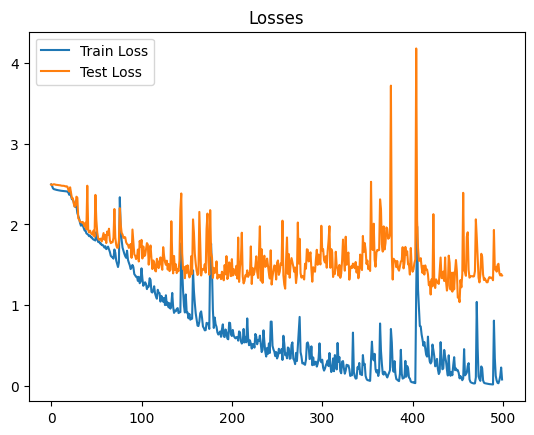

In [71]:
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['test_losses'], label='Test Loss')
plt.title("Losses")
plt.legend()
plt.show()

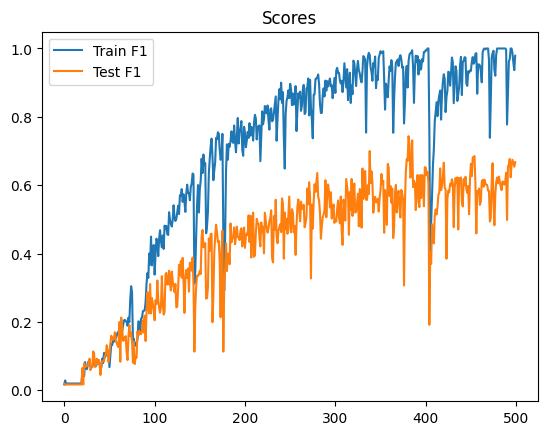

In [72]:
plt.plot(history['train_scores'], label="Train F1")
plt.plot(history['test_scores'], label="Test F1")
plt.title("Scores")
plt.legend()
plt.show()